## Loading package

In [2]:
#Loading possible necessary package
InlineBackend.figure_format='retina'
Sys.setenv("LANGUAGE"="EN")
library(ggplot2)
library(ggside)
library(vegan)
library(ggrepel)
library(tidyverse)
library(reshape2) 
library(UpSetR)
library(dplyr)
library(tidyr)
library(stringr)
library(plotly)
library(treemap)
library(treemapify)
library(ggalluvial)
library(ggrepel)
library(glue)
library(venn)
library(ggVennDiagram)
library(ggvenn)
library(SummarizedExperiment)
library(TreeSummarizedExperiment)
library(MultiAssayExperiment)
library(EnhancedVolcano)
library(DESeq2)
library(patchwork)
library(Biostrings)
library(phyloseq)

In [4]:
#set path
env_path <- "/path/00-ori"
Process_path <- "/path/02_proce"

## Part I Env data

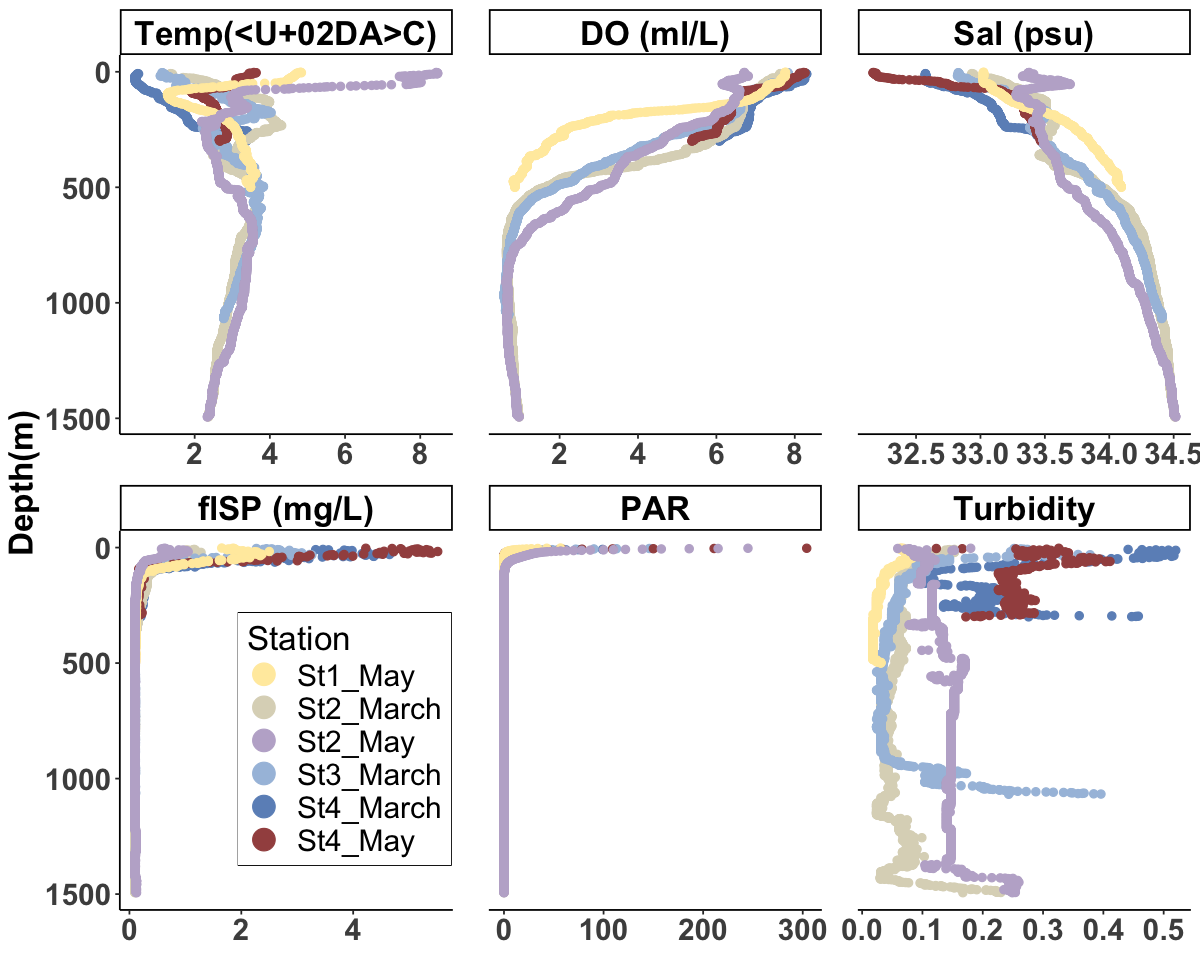

In [5]:
custom_color=c("#FFEBAD", "#DCD7C1", "#BFB1D0", "#A7C0DE", "#6C91C2", "#A4514F")

# Read and preprocess environmental data
env_df <- read.csv(file.path(env_path,"00_env.csv")) %>%
  pivot_longer(cols = -c(depSM, Station, Cruise), names_to = 'para', values_to = 'Value') %>%
  tidyr::unite(Sample, c(Station, Cruise), sep = "_", remove = TRUE) %>%
  mutate(Sample = str_replace(Sample, "S", "St"),
         para = recode(para, 
                       "t090C" = "Temp(˚C)",
                       "Oxygen" = "DO (ml/L)",
                       "sal00" = "Sal (psu)",
                       "flSP" = "flSP (mg/L)"),
         across(para, factor, levels = c("Temp(˚C)", "DO (ml/L)", "Sal (psu)", "flSP (mg/L)", "PAR", "Turbidity"))) 
# Set plot dimensions
# Generate plot
options(repr.plot.width=10, repr.plot.height=8)
FigS1 <- ggplot(env_df, aes(x = Value, y = depSM, group = Sample)) +
  geom_point(aes(color = Sample), size = 2) +
  labs(y = "Depth(m)") +
  scale_y_continuous(trans = "reverse") +
  guides(colour = guide_legend(override.aes = list(size = 6), title = "Station")) +
  facet_wrap(~para, ncol = 3, scales = "free_x") +
  scale_color_manual(values = custom_color) +
  theme_classic() +
  theme(legend.position = c(0.21, 0.2),
        legend.title = element_text(size = 20),
        legend.text = element_text(size = 18),
        legend.key.size = unit(0.7, "cm"),
        legend.box.background = element_rect(colour = "black"),
        legend.spacing.y = unit(0.1, 'cm'),
        strip.text.x = element_text(size = 20, colour = "#000000", face = "bold"),
        strip.background = element_rect(fill = "#ffffff"),
        axis.text.y = element_text(size = 18, face = "bold"),
        axis.text.x = element_text(size = 18, face = "bold"),
        axis.title.x = element_text(size = 0),
        axis.title.y = element_text(size = 20, face = "bold", colour = "#000000"),
        panel.spacing.x = unit(1.5, "lines"),
        panel.spacing.y = unit(0.6, "lines"))
# Print the plot
FigS1

## Part II Remove Potential Mutiple Celluar Taxon and Potential Sedimentary Contamination ASVs
- Embryophyceae (within Chloroplastida), Fungi, Metazoa and Rhodophyta were considered as potential multiple celluar organism
- We defined the ASV only unique to the BBL layer as BBL.Uniq ASV
- BBL.Uniq ASVs were considered as potential sedimentary resuspension contamination and were removed from downstream analysis


In [6]:
# input file was directly putput from the qiime2 pipeline
asv <- read.table(file.path(env_path,"out8-derep-filtered_table_clustered_ASV_with_tax.tsv"),skip = 1,sep = "\t", comment.char = "",check.names = FALSE,header = 1)%>%
  mutate(across(everything(), ~str_replace_all(., " ", "")))%>% # remove space
  separate(taxonomy, into = c("Domain", "Supergroup", "Division", "Subdivision", "Class", "Order", "Family", "Genus", "Species"), sep = ";", fill = "right") %>%
  mutate(across(everything(), ~str_replace_all(., ":nucl", "")))%>%
#split taxonomy columns
  replace_na(list(Domain = "unassigned", Supergroup = "unassigned", Division = "unassigned", Subdivision = "unassigned", Class = "unassigned", Order = "unassigned", Family = "unassigned", Genus = "unassigned", Species = "unassigned")) %>%
  filter(Domain != "unassigned")
  
#extract metazoa asvs
asv_metazoa <- asv %>% filter(Subdivision == "Metazoa")
#filter potential mutiple celluar taxon 
asv_prot <- asv %>% filter(Domain!= "unassigned" & Supergroup != "unassigned")  #Class != "Embryophyceae" & Subdivision != "Fungi" & Subdivision != "Metazoa" & Division !="Rhodophyta" & 
# input sample information file
sample_info_df <- read.csv(file.path(env_path, "00_sample_file.csv")) %>% 
    tidyr::unite(Station, Station_num:Cruise, sep = "_", remove = TRUE) %>%  # merge cruise info and station info into new column (Station: St1_May, St2_March etc)
    select(Sample,Station,Layers,Particle_types) # select need sample info for this part analysis

### ASVs Distribution

#### The BBL.Uniq ASVs number

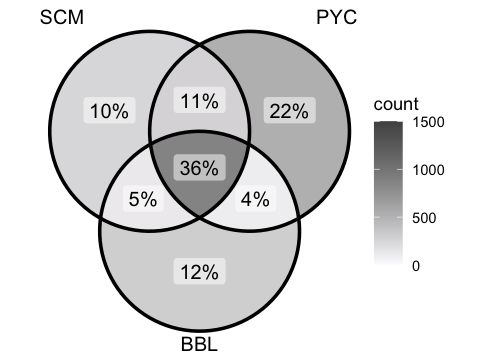

In [7]:
# ASV processing and merging with sample information
num_df <- asv_prot %>%
    mutate(ASVID = paste("ASV", row_number(), sep = "")) %>%  # simply the original ASV ID
    pivot_longer(cols = starts_with("A_M"), names_to = "Sample", values_to = "NumASV") %>% 
    mutate(NumASV = as.numeric(NumASV, na.rm = TRUE)) %>%
    left_join(sample_info_df, by = "Sample") %>% # add sample info into analysis dataframe
    group_by(ASVID, Layers) %>%
    summarise(NumASVs = sum(NumASV, na.rm = TRUE), .groups = "drop") %>%
    pivot_wider(names_from = Layers, values_from = NumASVs, values_fill = list(NumASVs = 0)) %>%
    mutate(across(c(PYC, SCM, BBL), ~ if_else(. > 0, ASVID, "")))
# Plotting Venn diagram
options(repr.plot.width=4, repr.plot.height=3)
FigS3 <- ggVennDiagram(list(SCM = num_df$SCM, PYC = num_df$PYC, BBL = num_df$BBL), label = "percent") + 
  scale_fill_gradient(low = "#fcfbfd", high = "#525252", limits = c(0, 1500)) +
  scale_color_manual(values = c("#000000", "#0000000", "#0000000"))
FigS3

#### The Relative Abundance of BBL.Uniq ASVs


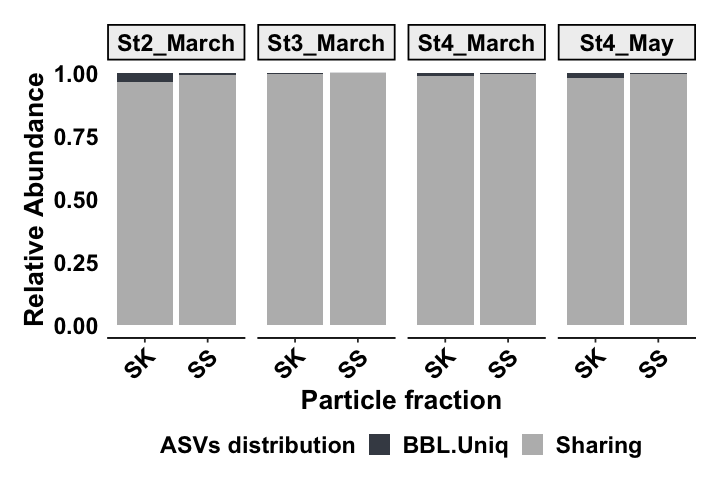

In [8]:
# ASV processing and merging with sample information
blluniq_df <- asv_prot %>%
    mutate(ASVID = paste("ASV", row_number(), sep = "")) %>%  
    pivot_longer(cols = starts_with("A_M"), names_to = "Sample", values_to = "NumASV") %>% 
    mutate(NumASV = as.numeric(NumASV, na.rm = TRUE)) %>%
    left_join(sample_info_df, by = "Sample") %>% # add sample info into analysis dataframe
    group_by(ASVID, Layers,Particle_types,Station) %>%
    summarise(NumASVs = sum(NumASV, na.rm = TRUE), .groups = "drop") %>%
    filter(Layers!="BBL")%>% 
    pivot_wider(names_from = c(Station,Layers,Particle_types),values_from = NumASVs)%>%
    mutate(BBL.Uniq = rowSums(across(2:25)), orig_label = if_else(BBL.Uniq == 0, "BBL.Uniq", NA_character_)) %>%
    select(ASVID,orig_label)
# blluniq_df %>% filter (orig_label != "NA")
RA_df <- asv_prot %>%
    mutate(ASVID = paste("ASV", row_number(), sep = "")) %>%  
    pivot_longer(cols = starts_with("A_M"), names_to = "Sample", values_to = "NumASV") %>% 
    mutate(NumASV = as.numeric(NumASV, na.rm = TRUE)) %>%
    left_join(sample_info_df, by = "Sample") %>%
    left_join(blluniq_df, by = "ASVID") %>%
    mutate(orig_label = replace_na(orig_label, "Sharing")) %>%
    filter(Layers == "BBL") %>%
    group_by(Station, Particle_types, orig_label) %>%
    summarise(NumASVs = sum(NumASV), .groups = "drop")

# ploting
options(repr.plot.width=6, repr.plot.height=4)
FigS6 <- ggplot(RA_df,aes(x=Particle_types,y=NumASVs,fill=orig_label))+
      geom_bar(stat = "identity",position = "fill")+
      facet_wrap(~ Station,ncol = 4)+
      scale_fill_manual(values = c("#434A54","#bababa"))+
      xlab("Particle fraction")+ylab("Relative Abundance")+labs(fill="ASVs distribution")+
      theme_classic()+
      theme(legend.position="bottom",
            legend.title=element_text(size=14, colour = "#000000",face="bold"),
            legend.text=element_text(size=14, colour = "#000000",face="bold"),
            legend.key.size = unit(0.5,"cm"),
            plot.margin=unit(c(1,1,1,1), units="line"),
            legend.margin=margin(0,0,0,0),
            legend.spacing.y  = unit(0.06, 'cm'),
            strip.text.x = element_text(size = 14, colour = "#000000",face="bold"),
            strip.text.y = element_text(size = 14, colour = "#000000",face="bold"),
            strip.background=element_rect(fill="#f0f0f0"),
            axis.text.x = element_text(size=14,angle=45, vjust = 1, hjust=1,face = "bold",colour ="#000000"),
            axis.text.y=element_text(size = 14,face="bold",colour ="#000000"),
            axis.title.x=element_text(size = 16,face="bold",colour ="#000000"),
            axis.title.y=element_text(size = 16,face="bold",colour ="#000000"),
            axis.line.y = element_line(color="white", linewidth = 0),
            axis.ticks.y = element_line(color = "white",linewidth = 0),
            panel.spacing.x=unit(0.5, "lines"),
            panel.spacing.y=unit(0.5, "lines"))
FigS6
# RA_df


## Part III Free BBL.Uniq ASVs

### Dealing Data

In [9]:
# ASV processing and merging with sample information
blluniq_df <- asv_prot %>%
    mutate(ASVID = paste("ASV", row_number(), sep = "")) %>%  
    pivot_longer(cols = starts_with("A_M"), names_to = "Sample", values_to = "NumASV") %>% 
    mutate(NumASV = as.numeric(NumASV, na.rm = TRUE)) %>%
    left_join(sample_info_df, by = "Sample") %>% # add sample info into analysis dataframe
    group_by(ASVID, Layers,Particle_types,Station) %>%
    dplyr::summarise(NumASVs = sum(NumASV, na.rm = TRUE), .groups = "drop") %>%
    filter(Layers!="BBL")%>% 
    pivot_wider(names_from = c(Station,Layers,Particle_types),values_from = NumASVs)%>%
    mutate(BBL.Uniq = rowSums(across(2:25)), orig_label = if_else(BBL.Uniq == 0, "BBL.Uniq", NA_character_)) %>%
    select(ASVID,orig_label)
free_blluniq_asv_prot_df <- asv_prot %>%
    filter(Domain!="Unassigned") %>%
    mutate(ASVID = paste("ASV", row_number(), sep = ""))%>%
    left_join(blluniq_df, by = "ASVID") %>%
    mutate(orig_label = replace_na(orig_label, "Sharing")) %>%
    filter(orig_label!="BBL.Uniq")

#### Rarefy Protists ASVs

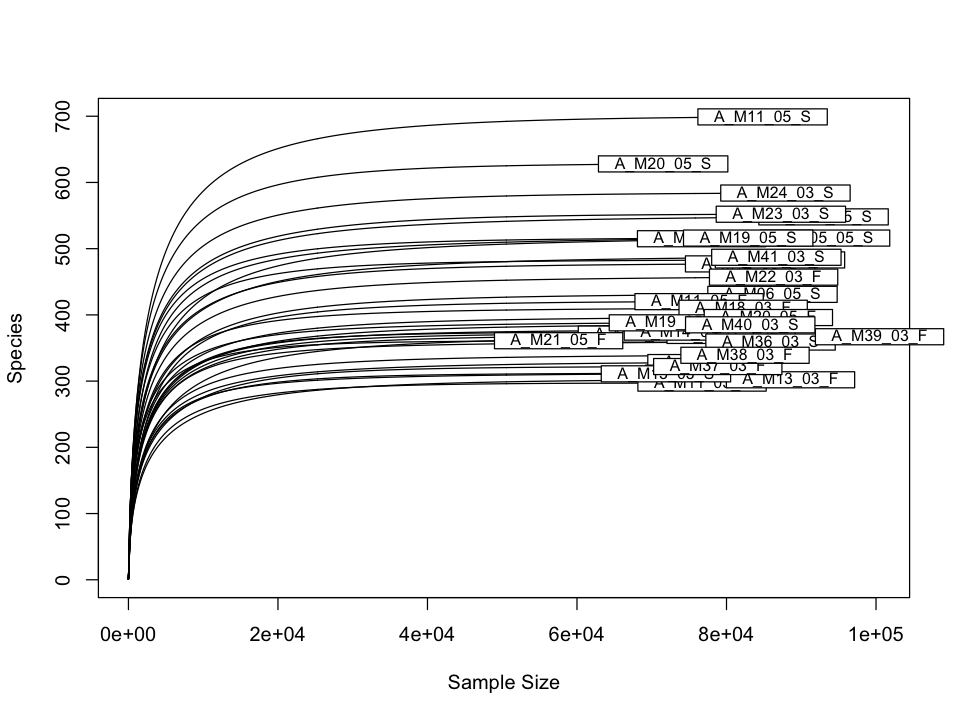

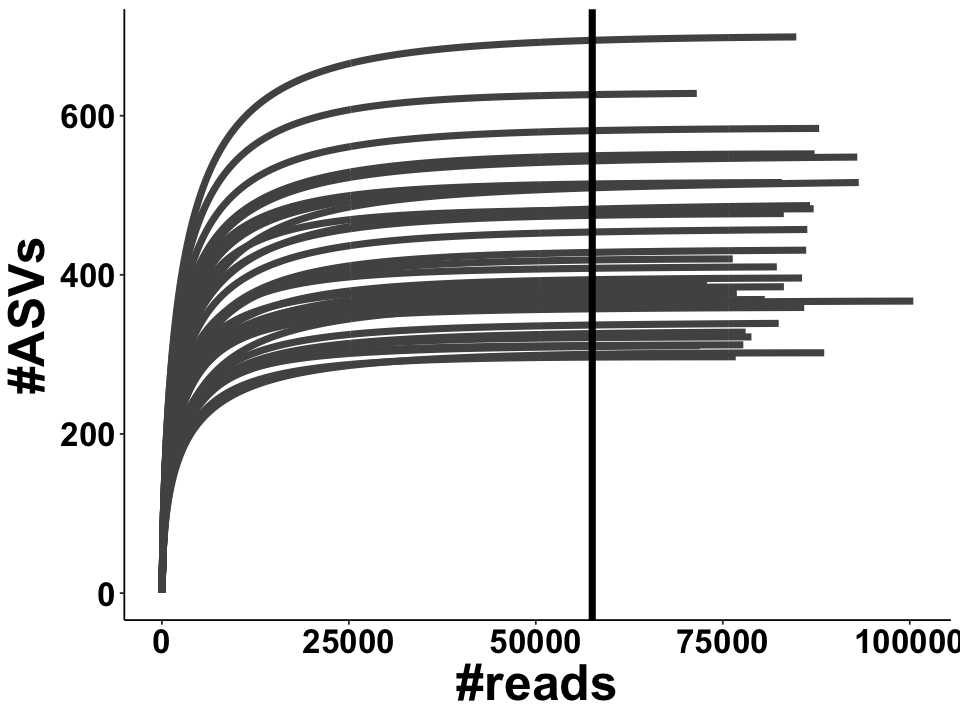

In [11]:
asv_prot_rarefy_df <- free_blluniq_asv_prot_df %>% select("#OTU ID", starts_with("A_M"))
precess_df <- melt(asv_prot_rarefy_df, id=c("#OTU ID"))

min_n_seqs <-  precess_df %>%
  mutate(value = as.numeric(value)) %>%
  group_by(variable) %>%
  summarise(n_seqs=sum(value)) %>%
  summarise(min=min(n_seqs)) %>%
  pull(min)
rarefy_df1 <- precess_df %>%
  pivot_wider(names_from = "#OTU ID",values_from = "value") %>%
  as.data.frame( )

rownames(rarefy_df1) <- rarefy_df1$variable
rarefy_df1 <- rarefy_df1[,-1] %>% mutate(across(everything(), ~ as.numeric(as.character(.))))
#Vegan rarefy
vegans <- rarefy(rarefy_df1,min_n_seqs) %>%
  as_tibble(rownames = "variable")

sub_asv_prot <- as.data.frame(t(rrarefy(rarefy_df1,sample=min_n_seqs)))

options(repr.plot.width=8, repr.plot.height=6)
map_dfr(rarecurve(rarefy_df1,step=199),bind_rows) %>% 
  bind_cols(Group=row.names(rarefy_df1),.) %>%
  pivot_longer(-Group) %>%
  drop_na() %>%
  mutate(n_seqs=as.numeric(str_replace(name,"N",""))) %>%
  ggplot(aes(x=n_seqs,y=value,group=Group))+
  geom_line(linewidth=2,colour ="#525252") +
  geom_vline(xintercept = min_n_seqs,color="#000000",linewidth=2)+
  xlab("#reads")+
  ylab("#ASVs")+
  theme_classic()+
    theme(axis.text.y = element_text(size=20,face = "bold",colour ="#000000"),
        axis.text.x = element_text(size=20,face = "bold",colour ="#000000"),
        axis.title.x=element_text(size = 30,face="bold",colour ="#000000"),
        axis.title.y=element_text(size = 30,face="bold",colour ="#000000"))

# after rarefied, some of the ASVs ture to 0 in all samples
sub_asv_protist <- read.csv(file.path(Process_path,"0_asv_sub.csv"),header = TRUE) %>%
    mutate(sum_AR = rowSums(select(.,starts_with("A_M")))) %>%
    filter(sum_AR != 0) %>%
    select(-sum_AR)
write.csv(sub_asv_protist,file.path(Process_path,"1_asv_sub.csv"),row.names=FALSE)

#### Alpha diversity (richness & evenness)

Warning message:
"The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
i Please use the `linewidth` argument instead."


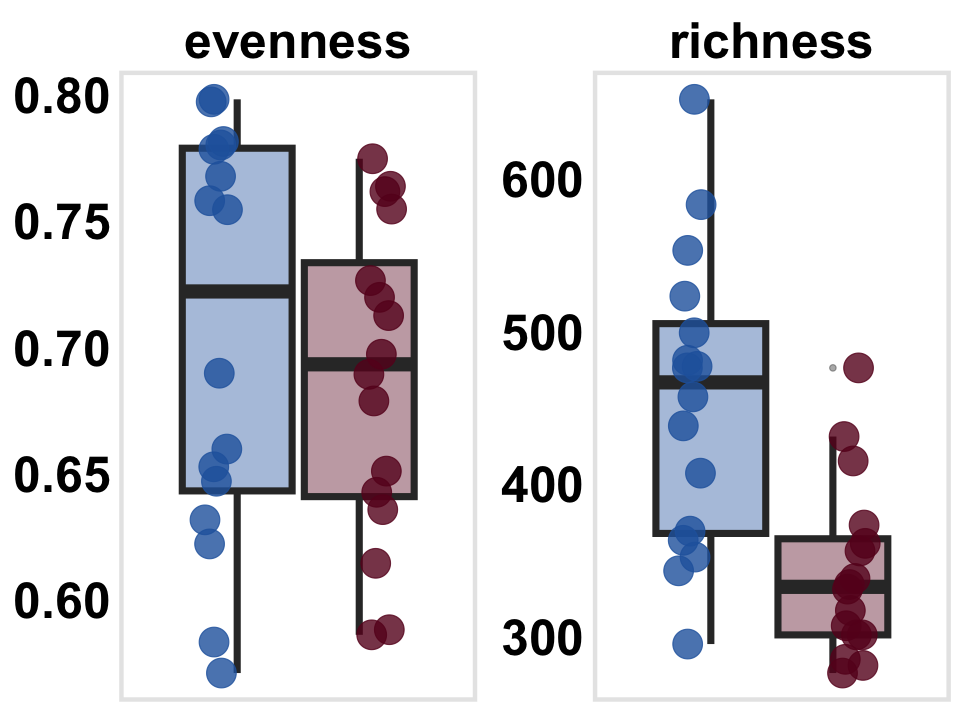

In [12]:
#All protists Alpha diversity calculation
sub_asv_protist <- read.csv(file.path(Process_path,"1_asv_sub.csv"),header = TRUE) %>% select(starts_with("A_M")) # 0_asv_sub.csv was generated at rarefy step
# calculate alpha diversity with vegan
ASV_protist_S <- vegan::diversity(t(sub_asv_protist),"shannon")
ASV_protist_R = vegan::specnumber(t(sub_asv_protist))
ASV_protist_J = ASV_protist_S/log(ASV_protist_R, base=exp(1))

Shannon <- ASV_protist_S %>% as.data.frame()%>% rename("." = "shannon")
Richness <- ASV_protist_R %>% as.data.frame()%>% rename("." = "richness")
Evenness <- ASV_protist_J %>% as.data.frame()%>% rename("." = "evenness")
alpha_df <- cbind(Shannon,Richness,Evenness) %>% 
    rownames_to_column(var = "Sample")%>% # transfer rowname into new column
    pivot_longer(cols = c(shannon,richness,evenness),names_to = "Index",values_to = "value") %>%
    left_join(sample_info_df,by = "Sample")%>%
    filter(Index != "shannon") %>%
    mutate(across(Particle_types,factor, levels=c("SS","SK")))
    
options(repr.plot.width=8, repr.plot.height=6)
pd = ggplot2::position_jitterdodge(dodge.width = 0.75, jitter.width = 0.3, seed = 1)
Fig1 <- ggplot(alpha_df, aes(x=Particle_types,y=value,fill=Particle_types))+
    geom_boxplot(alpha=0.4,width = 1.5,size=2)+
    geom_point(aes(color=Particle_types),size=8,alpha=0.8,position = pd)+
    facet_wrap(~Index, scales = "free_y")+
    theme_linedraw(base_line_size = 0)+
    theme(legend.position="none",
        strip.text.x = element_text(size = 30, colour = "#000000",face="bold"),
        strip.background=element_blank(),
        axis.text.y = element_text(size=30,face = "bold",colour ="#000000"),
        axis.text.x = element_blank(),
        axis.title.x=element_text(size = 0),
        axis.title.y=element_text(size = 0,face="bold",colour ="#000000"),
        panel.spacing.x=unit(1, "lines"),
        panel.border = element_rect(colour = "#e7e7e7",fill = NA,size = 2.5))+
    scale_color_manual(values=c("#2464AB","#660020"))+
    scale_fill_manual(values=c("#2464AB","#660020"))+
    labs(fill="Particle fraction",color="Particle fraction")
Fig1

##### wilcox test

In [13]:
# test phytoplankton subsampled
alpha_test_df <- alpha_df%>% select(Sample,Layers,Particle_types,Index,value)%>% 
    pivot_wider(names_from =Index,values_from = value )%>%
    arrange(desc(Sample))
#evenness
Suspended <- subset(alpha_test_df, Particle_types=="SS",evenness,drop=TRUE)
Sinking <- subset(alpha_test_df, Particle_types=="SK",evenness,drop=TRUE)

wilcox_even <- wilcox.test(Suspended, Sinking, paired = TRUE)
wilcox_even
#richness
Suspended <- subset(alpha_test_df, Particle_types=="SS",richness,drop=TRUE)
Sinking <- subset(alpha_test_df, Particle_types=="SK",richness,drop=TRUE)

wilcox_rich <- wilcox.test(Suspended, Sinking, paired = TRUE)
wilcox_rich


	Wilcoxon signed rank exact test

data:  Suspended and Sinking
V = 88, p-value = 0.3225
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon signed rank exact test

data:  Suspended and Sinking
V = 136, p-value = 3.052e-05
alternative hypothesis: true location shift is not equal to 0


#### Beta diversity

Warning message:
"Removed 1 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_text_repel()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_text_repel()`)."


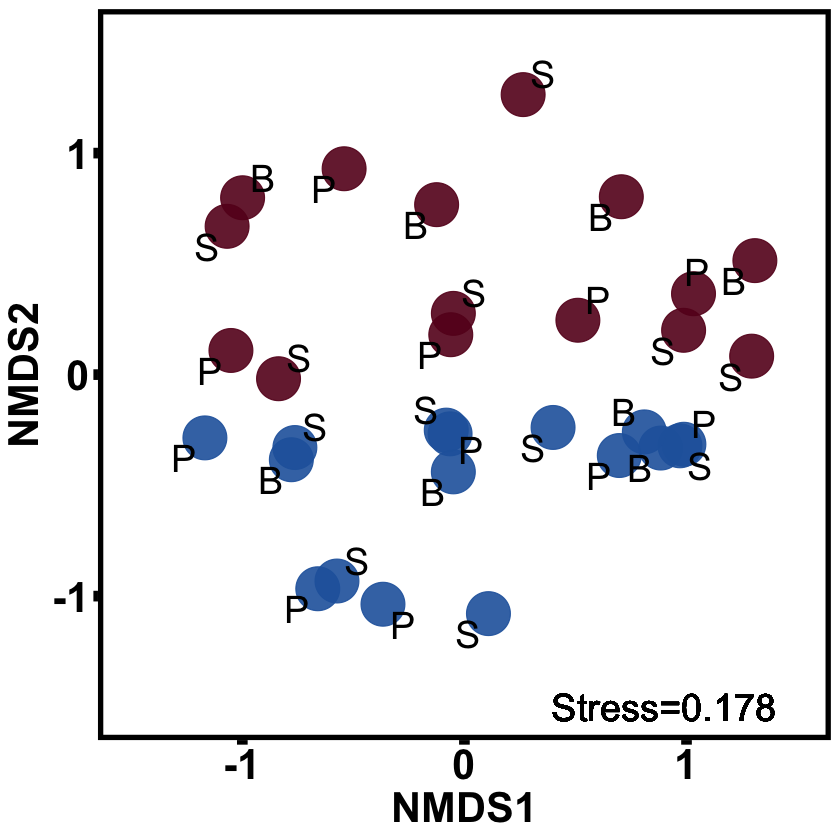

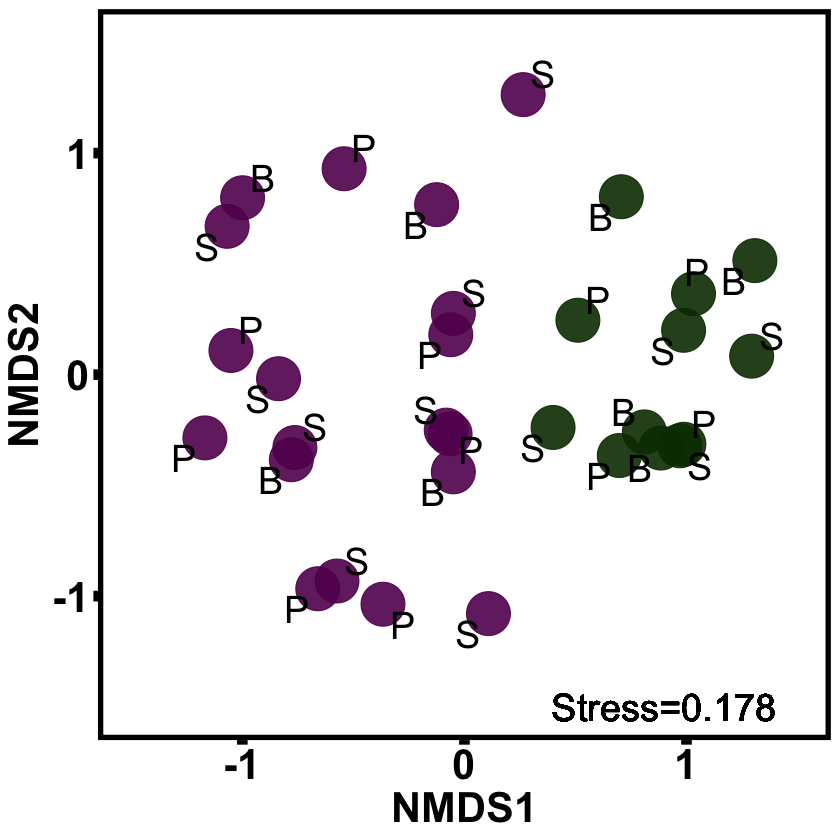

In [529]:

# # bray-curtis dissimilarity
# sub_asv_protist <- read.csv(file.path(Process_path,"1_asv_sub.csv"),header = TRUE) %>% select(starts_with("A_M")) # 0_asv_sub.csv was generated at rarefy step
# # colSums(sub_asv_protist)
# # sub_asv_protist_precent <- sub_asv_protist/colSums(sub_asv_protist)
# tab_vegv2 <- vegdist(t(sub_asv_protist), meth="bray", binary= F)
# nmdsv2 = monoMDS(tab_vegv2)
# nmdsv2
sample_info_df <- read.csv(file.path(env_path, "00_sample_file.csv")) %>% 
    tidyr::unite(Station, Station_num:Cruise, sep = "_", remove = TRUE) %>%  # merge cruise info and station info into new column (Station: St1_May, St2_March etc)
    select(Sample,Station,Layers,Particle_types,Condition) %>%# select need sample info for this part analysis
    mutate(Layers = str_replace_all(Layers, c("PYC" = "P", "SCM" = "S", "BBL" = "B")))%>%
    mutate(Condition = str_replace_all(Condition, c("DB" = "diatom-abundant", "NDB" = "dinophyceae-abundant")))

NMDSv2 = data.frame(MDS1 = nmdsv2$points[,1], MDS2 = nmdsv2$points[,2]) %>% cbind(sample_info_df)
options(repr.plot.width=7, repr.plot.height=7)
Fig3 <- ggplot(NMDSv2,aes(x=MDS1,y=MDS2))+
  geom_point(size=12,aes(colour=Particle_types),alpha=0.9)+ #,shape=Condition
  xlim(-1.5,1.5)+
  ylim(-1.5,1.5)+
  geom_text_repel(aes(label = Layers),colour = "#000000",size=8)+
  geom_text(x=0.9,y=-1.5,label="Stress=0.178",color="#000000",size=8)+
  # stat_ellipse(aes(fill=Particle_types),geom = "polygon",type = "convex",level = 0.95,alpha=0.2,show.legend = FALSE)+
  theme(axis.ticks = element_line(colour = "#000000", size = 3),
        axis.text.y = element_text(colour = "#000000",size=25,face = "bold"),
        axis.text.x = element_text(colour = "#000000",face = "bold",size=25),
        axis.title.y = element_text(face = "bold",colour = "#000000",size = 25),
        axis.title.x = element_text(face = "bold",colour = "#000000",size = 25),
        panel.background = element_blank(),
        panel.border = element_rect(colour = "#000000",fill = NA,size = 3),
        legend.position = "none",
        legend.title = element_text(size=20, colour = "#000000",face = "bold"),
        legend.direction ="vertical",
        legend.key = element_blank())+ 
        labs(x="NMDS1",colour="Particle fraction",y="NMDS2")+
        scale_color_manual(values=c("#660020","#2464AB"))+
        scale_fill_manual(values=c("#660020","#2464AB"))
Fig3

Fig3_1 <- ggplot(NMDSv2,aes(x=MDS1,y=MDS2))+
  geom_point(size=12,aes(colour=Condition),alpha=0.9)+ #,shape=Condition
  xlim(-1.5,1.5)+
  ylim(-1.5,1.5)+
  geom_text_repel(aes(label = Layers),colour = "#000000",size=8)+
  geom_text(x=0.9,y=-1.5,label="Stress=0.178",color="#000000",size=8)+
  # stat_ellipse(aes(fill=Particle_types),geom = "polygon",type = "convex",level = 0.95,alpha=0.2,show.legend = FALSE)+
  theme(axis.ticks = element_line(colour = "#000000", size = 3),
        axis.text.y = element_text(colour = "#000000",size=25,face = "bold"),
        axis.text.x = element_text(colour = "#000000",face = "bold",size=25),
        axis.title.y = element_text(face = "bold",colour = "#000000",size = 25),
        axis.title.x = element_text(face = "bold",colour = "#000000",size = 25),
        panel.background = element_blank(),
        panel.border = element_rect(colour = "#000000",fill = NA,size = 3),
        legend.position = "none",
        legend.title = element_text(size=20, colour = "#000000",face = "bold"),
        legend.direction ="vertical",
        legend.key = element_blank())+ 
        labs(x="NMDS1",colour="Particle fraction",y="NMDS2")+
        scale_color_manual(values=c("#63045d","#093801"))+
        scale_fill_manual(values=c("#63045d","#093801"))
Fig3_1


##### adonis test

In [55]:

asv <- decostand(t(sub_asv_protist), "hellinger")
dis<-vegdist(asv,method = 'bray')
#ANOSIM
anosim_asv<-anosim(dis,sample_info_df$Particle_types,permutations = 9999)
anosim_asv
#PERMANOVA
asv.div<-adonis2(dis~as.factor(sample_info_df$Particle_types),permutations=9999)
asv.div
asv.div1<-adonis2(dis~as.factor(sample_info_df$Condition),permutations=9999)
asv.div1


Call:
anosim(x = dis, grouping = sample_info_df$Particle_types, permutations = 9999) 
Dissimilarity: bray 

ANOSIM statistic R: 0.2281 
      Significance: 0.001 

Permutation: free
Number of permutations: 9999


,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
as.factor(sample_info_df$Particle_types),1,0.5272854,0.09595429,3.184163,0.0032
Residual,30,4.9678875,0.90404571,NA,NA
Total,31,5.4951729,1.00000000,NA,NA


,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
as.factor(sample_info_df$Condition),1,1.371632,0.2496067,9.979037,1e-04
Residual,30,4.123541,0.7503933,NA,NA
Total,31,5.495173,1.0000000,NA,NA


##### Add environmental para

In [56]:
#calculating+ suspended
Protist_sus <- read.csv(file.path(Process_path,"1_asv_sub.csv"),header = TRUE) %>% select(ends_with("_S"))
sample_info_df <- read.csv(file.path(env_path, "00_sample_file.csv")) %>%
    filter(Particle_types == "SS")%>% 
    mutate(NO2.NO3=NO2+NO3)%>%
    tidyr::unite(Station, Station_num:Cruise, sep = "_", remove = TRUE) %>%  # merge cruise info and station info into new column (Station: St1_May, St2_March etc)
    mutate(Layers = str_replace_all(Layers, c("PYC" = "P", "SCM" = "S", "BBL" = "B"))) %>%
    tidyr::unite(station, c(Station, Layers),sep = ".", remove=TRUE)
# sample_file$Label <- str_replace(sample_file$Label,"_Sus","")
env <- sample_info_df %>% select(Sal,ChlaM_L,Temperature,DO,NO2.NO3,PO4,SiOH4,POC_flux,PON_flux)
colnames(env)<-c("Sal","Chla","Temp","DO","NO2+NO3","PO4","SiOH4","POC_flux","PON_flux")

nmdsv4= metaMDS(vegdist(t(Protist_sus), meth="bray", binary= F))
en4 = envfit(nmdsv4, env, permutations = 9999, add=TRUE, w=weights(nmdsv4))
data.scores = as.data.frame(scores(nmdsv4))
data.scores$Dominant = sample_info_df$Dominant
data.scores$station=sample_info_df$station
en_coord_cont = as.data.frame(scores(en4,"vectors"))*ordiArrowMul(en4)
en_coord_cont$Pvalue <- en4$vectors$pvals
en4$vectors
en_coord_cont

Run 0 stress 0.07195684 
Run 1 stress 0.07195684 
... Procrustes: rmse 2.225371e-05  max resid 4.864969e-05 
... Similar to previous best
Run 2 stress 0.07195684 
... Procrustes: rmse 2.256375e-05  max resid 4.810001e-05 
... Similar to previous best
Run 3 stress 0.1750339 
Run 4 stress 0.07195685 
... Procrustes: rmse 3.806819e-05  max resid 8.869343e-05 
... Similar to previous best
Run 5 stress 0.07195685 
... Procrustes: rmse 1.620846e-05  max resid 2.747053e-05 
... Similar to previous best
Run 6 stress 0.07195684 
... New best solution
... Procrustes: rmse 1.353033e-05  max resid 2.421786e-05 
... Similar to previous best
Run 7 stress 0.07195686 
... Procrustes: rmse 5.385549e-05  max resid 0.000152161 
... Similar to previous best
Run 8 stress 0.07195684 
... Procrustes: rmse 1.29936e-05  max resid 3.35092e-05 
... Similar to previous best
Run 9 stress 0.07195684 
... Procrustes: rmse 7.308196e-06  max resid 1.218566e-05 
... Similar to previous best
Run 10 stress 0.07195684 
..

            NMDS1    NMDS2     r2 Pr(>r)    
Sal       0.29392 -0.95583 0.1132 0.4671    
Chla      0.44450  0.89578 0.7625 0.0003 ***
Temp     -0.54717 -0.83702 0.4448 0.0180 *  
DO       -0.99997 -0.00726 0.0409 0.7996    
NO2+NO3   0.72964  0.68383 0.0687 0.6359    
PO4       0.62728  0.77879 0.0847 0.5689    
SiOH4     0.96093  0.27679 0.0893 0.5791    
POC_flux -0.20973  0.97776 0.2380 0.1598    
PON_flux -0.45231  0.89186 0.3866 0.0350 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
Permutation: free
Number of permutations: 9999

,NMDS1,NMDS2,Pvalue
,<dbl>,<dbl>,<dbl>
Sal,0.09481322,-0.308330358,0.4671
Chla,0.37215844,0.750000000,0.0003
Temp,-0.34991809,-0.535282971,0.0180
DO,-0.19380949,-0.001406405,0.7996
NO2+NO3,0.18343343,0.171915094,0.6359
PO4,0.17509786,0.217391890,0.5689
SiOH4,0.27533842,0.079311050,0.5791
POC_flux,-0.09809834,0.457329656,0.1598
PON_flux,-0.26967784,0.531747703,0.0350


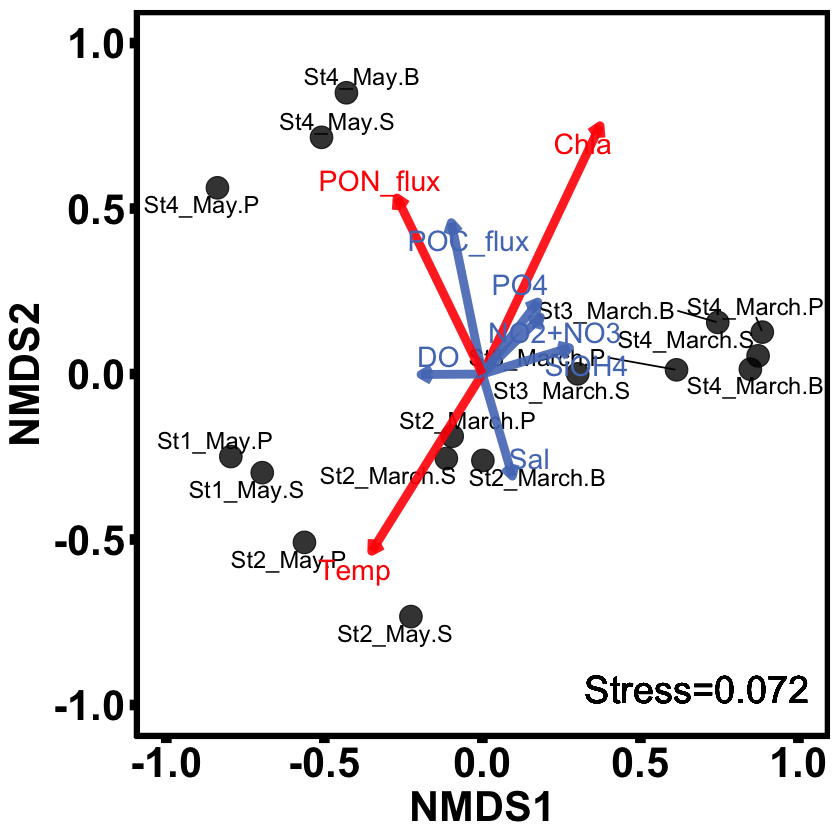

In [57]:
#ploting
options(repr.plot.width=7, repr.plot.height=7)
Fig3_1 <- ggplot(data = data.scores, aes(x = NMDS1, y = NMDS2)) + 
     geom_point(data = data.scores, size = 6, alpha = 0.8,colour = "#000000") +
     geom_text_repel(aes(label = station), size = 5,colour = "#000000")+
     scale_colour_manual(values = c("#00441b", "#40004b")) +
     theme_classic2()+
     geom_text(x=0.68,y=-0.95,label="Stress=0.072",color="#000000",size=8)+
     xlim(-1,1)+
     ylim(-1,1)+
     geom_segment(data = en_coord_cont,
                  aes(x = 0, y = 0, xend = NMDS1, yend = NMDS2),
                  size =2.5, 
                  alpha = 0.9,
                  arrow = arrow(length = unit(0.1, "inches")),
                  colour =ifelse(en_coord_cont$Pvalue<=0.05,"red","#547ac0"))+
     geom_text_repel(data = en_coord_cont,aes(x = NMDS1,
                                              y = NMDS2,
                                              label = row.names(en_coord_cont)),
                     colour =ifelse(en_coord_cont$Pvalue<0.05,"red","#547ac0"),
                     size = 6)+
     theme(axis.ticks = element_line(colour = "#000000", size = 3),
           axis.title = element_text(size = 25, face = "bold", colour = "#000000"),
           panel.background = element_blank(), 
           panel.border = element_rect(fill = NA, colour = "#000000",size=3), 
           axis.text = element_text(colour = "#000000",face = "bold",size=25), 
           legend.position="none"
          ) 
Fig3_1

## Part IV Trophic mode classification

In [15]:
#sample info
sample_info_df <- read.csv(file.path(env_path, "00_sample_file.csv")) %>% 
    tidyr::unite(Station, Station_num,Cruise, sep = "_", remove = TRUE)

# trophic mode
asv2trophic_df <- read.csv(file.path(env_path,"ASVs2TrophicMode.csv"),check.names = FALSE,fileEncoding = "UTF-8-BOM")

# asv sequence
read_fasta_to_df <- function(fasta_file) {
  fasta_seqs <- readDNAStringSet(fasta_file)
  df <- data.frame(sequence = as.character(fasta_seqs), stringsAsFactors = FALSE) %>%#seqID_qiime2 = names(fasta_seqs), 
  rownames_to_column(var="seqID_qiime2")
  return(df)
}

asv_seq <- read_fasta_to_df(file.path(env_path,"2416_asv_seq.fasta"))
# taxon2trophic_df
Oyashio18sMetadata_df <- read.csv(file.path(Process_path,"1_asv_sub.csv"),header = TRUE) %>% 
    rename_with(~ "seqID_qiime2", .cols = names(.)[1]) %>% # replace first column name
    left_join(asv2trophic_df, by="seqID_qiime2") %>%  #add taxon info.
    left_join(asv_seq, by="seqID_qiime2") %>%  # add seq info
    dplyr::mutate(ASVID = paste("ASV", row_number(), sep = ""))%>%# simplif the ASV ID
    pivot_longer(cols = starts_with("A_"),names_to = "Sample",values_to = "asvCount") %>% # transform the dataframe
    left_join(sample_info_df,by = "Sample") %>% #add sample info
    select(ASVID, everything())

### Trophic Mode Based Alpha Diversity

#### Heterotroph

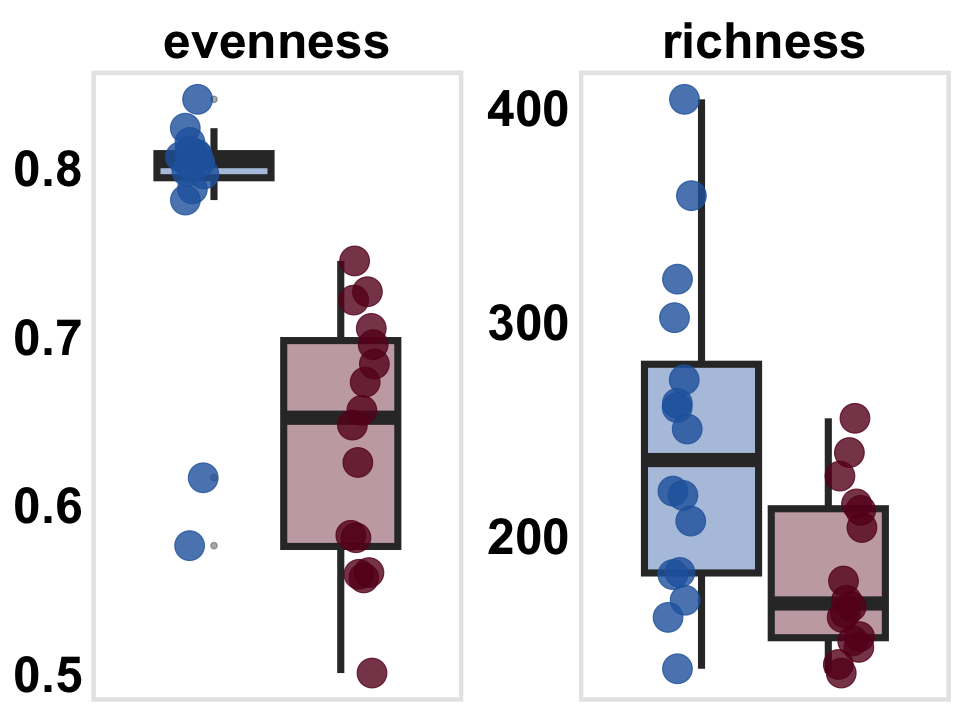

In [11]:
#All protists Alpha diversity calculation
hetero_df <- Oyashio18sMetadata_df %>% filter(PotentialTrophicMode %in% c("Parasite","Phagotroph")) %>%
                                       select(Sample,asvCount,ASVID)%>%
                                       pivot_wider(names_from = Sample,values_from = asvCount) %>%
                                       select(starts_with("A_M")) 
# calculate alpha diversity with vegan
ASV_protist_S = vegan::diversity(t(hetero_df),"shannon")
ASV_protist_R = vegan::specnumber(t(hetero_df))
ASV_protist_J = ASV_protist_S/log(ASV_protist_R, base=exp(1))

Shannon <- ASV_protist_S %>% as.data.frame()%>% rename("." = "shannon")
Richness <- ASV_protist_R %>% as.data.frame()%>% rename("." = "richness")
Evenness <- ASV_protist_J %>% as.data.frame()%>% rename("." = "evenness")
alpha_df <- cbind(Shannon,Richness,Evenness) %>% 
    rownames_to_column(var = "Sample")%>% # transfer rowname into new column
    pivot_longer(cols = c(shannon,richness,evenness),names_to = "Index",values_to = "value") %>%
    left_join(sample_info_df,by = "Sample")%>%
    filter(Index != "shannon") %>%
    mutate(across(Particle_types,factor, levels=c("SS","SK")))
    
options(repr.plot.width=8, repr.plot.height=6)
pd = ggplot2::position_jitterdodge(dodge.width = 0.75, jitter.width = 0.3, seed = 1)
Fig1 <- ggplot(alpha_df, aes(x=Particle_types,y=value,fill=Particle_types))+
    geom_boxplot(alpha=0.4,width = 1.5,size=2)+
    geom_point(aes(color=Particle_types),size=8,alpha=0.8,position = pd)+
    facet_wrap(~Index, scales = "free_y")+
    theme_linedraw(base_line_size = 0)+
    theme(legend.position="none",
        strip.text.x = element_text(size = 30, colour = "#000000",face="bold"),
        strip.background=element_blank(),
        axis.text.y = element_text(size=30,face = "bold",colour ="#000000"),
        axis.text.x = element_blank(),
        axis.title.x=element_text(size = 0),
        axis.title.y=element_text(size = 0,face="bold",colour ="#000000"),
        panel.spacing.x=unit(1, "lines"),
        panel.border = element_rect(colour = "#e7e7e7",fill = NA,size = 2.5))+
    scale_color_manual(values=c("#2464AB","#660020"))+
    scale_fill_manual(values=c("#2464AB","#660020"))+
    labs(fill="Particle fraction",color="Particle fraction")
Fig1

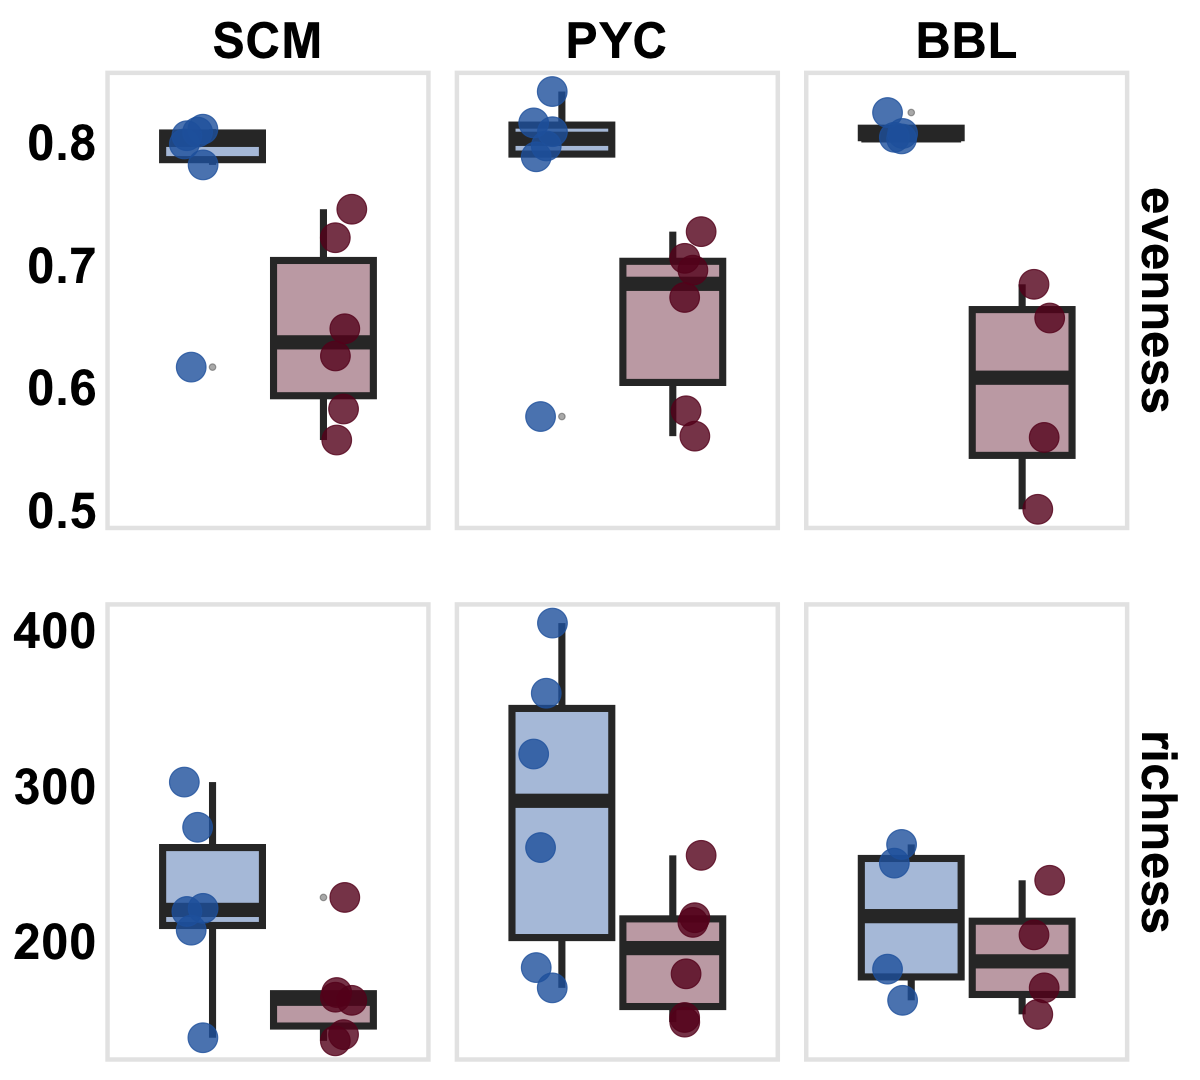

In [40]:
#All protists Alpha diversity calculation
hetero_df <- Oyashio18sMetadata_df %>% filter(PotentialTrophicMode %in% c("Parasite","Phagotroph")) %>%
                                       select(Sample,asvCount,ASVID)%>%
                                       pivot_wider(names_from = Sample,values_from = asvCount) %>%
                                       select(starts_with("A_M")) 
# calculate alpha diversity with vegan
ASV_protist_S = vegan::diversity(t(hetero_df),"shannon")
ASV_protist_R = vegan::specnumber(t(hetero_df))
ASV_protist_J = ASV_protist_S/log(ASV_protist_R, base=exp(1))

Shannon <- ASV_protist_S %>% as.data.frame()%>% rename("." = "shannon")
Richness <- ASV_protist_R %>% as.data.frame()%>% rename("." = "richness")
Evenness <- ASV_protist_J %>% as.data.frame()%>% rename("." = "evenness")
layers_alpha_df <- cbind(Shannon,Richness,Evenness) %>% 
    rownames_to_column(var = "Sample")%>% # transfer rowname into new column
    pivot_longer(cols = c(shannon,richness,evenness),names_to = "Index",values_to = "value") %>%
    left_join(sample_info_df,by = "Sample")%>%
    filter(Index != "shannon") %>%
    mutate(across(Particle_types,factor, levels=c("SS","SK"))) %>%
    mutate(across(Layers, factor,levels=c("SCM","PYC","BBL")))
    
options(repr.plot.width=10, repr.plot.height=9)
pd = ggplot2::position_jitterdodge(dodge.width = 0.75, jitter.width = 0.3, seed = 1)
Fig1 <- ggplot(layers_alpha_df, aes(x=Particle_types,y=value,fill=Particle_types))+
    geom_boxplot(alpha=0.4,width = 1.5,size=2)+
    geom_point(aes(color=Particle_types),size=8,alpha=0.8,position = pd)+
    facet_grid(Index~Layers, scales = "free")+
    theme_linedraw(base_line_size = 0)+
    theme(legend.position="none",
        strip.text.x = element_text(size = 30, colour = "#000000",face="bold"),
        strip.text.y = element_text(size = 30, colour = "#000000",face="bold"),
        strip.background=element_blank(),
        axis.text.y = element_text(size=30,face = "bold",colour ="#000000"),
        axis.text.x = element_blank(),
        axis.title.x=element_text(size = 0),
        axis.title.y=element_text(size = 0,face="bold",colour ="#000000"),
        panel.spacing.x=unit(1, "lines"),
        panel.spacing.y=unit(3, "lines"),
        panel.border = element_rect(colour = "#e7e7e7",fill = NA,size = 2.5))+
    scale_color_manual(values=c("#2464AB","#660020"))+
    scale_fill_manual(values=c("#2464AB","#660020"))+
    labs(fill="Particle fraction",color="Particle fraction")
Fig1

##### Wilcox test

In [41]:
# test phytoplankton subsampled
alpha_test_df <- alpha_df%>% select(Sample,Layers,Particle_types,Index,value)%>% 
    pivot_wider(names_from =Index,values_from = value )%>%
    arrange(desc(Sample))
#evenness
Suspended <- subset(alpha_test_df, Particle_types=="SS",evenness,drop=TRUE)
Sinking <- subset(alpha_test_df, Particle_types=="SK",evenness,drop=TRUE)

wilcox_even <- wilcox.test(Suspended, Sinking, paired = TRUE)
wilcox_even
#richness
Suspended <- subset(alpha_test_df, Particle_types=="SS",richness,drop=TRUE)
Sinking <- subset(alpha_test_df, Particle_types=="SK",richness,drop=TRUE)

wilcox_rich <- wilcox.test(Suspended, Sinking, paired = TRUE)
wilcox_rich


	Wilcoxon signed rank exact test

data:  Suspended and Sinking
V = 37, p-value = 0.1167
alternative hypothesis: true location shift is not equal to 0


Warning message in wilcox.test.default(Suspended, Sinking, paired = TRUE):
"cannot compute exact p-value with ties"



	Wilcoxon signed rank test with continuity correction

data:  Suspended and Sinking
V = 134, p-value = 0.0007024
alternative hypothesis: true location shift is not equal to 0


In [42]:
#SCM
alpha_test_df <- layers_alpha_df%>% select(Sample,Layers,Particle_types,Index,value)%>%
    filter(Layers == "SCM") %>%
    pivot_wider(names_from =Index,values_from = value )%>%
    arrange(desc(Sample))
#evenness
Suspended <- subset(alpha_test_df, Particle_types=="SS",evenness,drop=TRUE)
Sinking <- subset(alpha_test_df, Particle_types=="SK",evenness,drop=TRUE)
wilcox_even <- wilcox.test(Suspended, Sinking, paired = TRUE)
wilcox_even
#richness
Suspended <- subset(alpha_test_df, Particle_types=="SS",richness,drop=TRUE)
Sinking <- subset(alpha_test_df, Particle_types=="SK",richness,drop=TRUE)

wilcox_rich <- wilcox.test(Suspended, Sinking, paired = TRUE)
wilcox_rich


	Wilcoxon signed rank exact test

data:  Suspended and Sinking
V = 21, p-value = 0.03125
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon signed rank exact test

data:  Suspended and Sinking
V = 21, p-value = 0.03125
alternative hypothesis: true location shift is not equal to 0


In [43]:
#PYC
alpha_test_df <- layers_alpha_df%>% select(Sample,Layers,Particle_types,Index,value)%>%
    filter(Layers == "PYC") %>%
    pivot_wider(names_from =Index,values_from = value )%>%
    arrange(desc(Sample))
#evenness
Suspended <- subset(alpha_test_df, Particle_types=="SS",evenness,drop=TRUE)
Sinking <- subset(alpha_test_df, Particle_types=="SK",evenness,drop=TRUE)
wilcox_even <- wilcox.test(Suspended, Sinking, paired = TRUE)
wilcox_even
#richness
Suspended <- subset(alpha_test_df, Particle_types=="SS",richness,drop=TRUE)
Sinking <- subset(alpha_test_df, Particle_types=="SK",richness,drop=TRUE)

wilcox_rich <- wilcox.test(Suspended, Sinking, paired = TRUE)
wilcox_rich


	Wilcoxon signed rank exact test

data:  Suspended and Sinking
V = 20, p-value = 0.0625
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon signed rank exact test

data:  Suspended and Sinking
V = 21, p-value = 0.03125
alternative hypothesis: true location shift is not equal to 0


In [44]:
#BBL
alpha_test_df <- layers_alpha_df%>% select(Sample,Layers,Particle_types,Index,value)%>%
    filter(Layers == "BBL") %>%
    pivot_wider(names_from =Index,values_from = value )%>%
    arrange(desc(Sample))
#evenness
Suspended <- subset(alpha_test_df, Particle_types=="SS",evenness,drop=TRUE)
Sinking <- subset(alpha_test_df, Particle_types=="SK",evenness,drop=TRUE)
wilcox_even <- wilcox.test(Suspended, Sinking, paired = TRUE)
wilcox_even
#richness
Suspended <- subset(alpha_test_df, Particle_types=="SS",richness,drop=TRUE)
Sinking <- subset(alpha_test_df, Particle_types=="SK",richness,drop=TRUE)

wilcox_rich <- wilcox.test(Suspended, Sinking, paired = TRUE)
wilcox_rich


	Wilcoxon signed rank exact test

data:  Suspended and Sinking
V = 10, p-value = 0.125
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon signed rank exact test

data:  Suspended and Sinking
V = 9, p-value = 0.25
alternative hypothesis: true location shift is not equal to 0


#### Phototroph

#### Phototroph

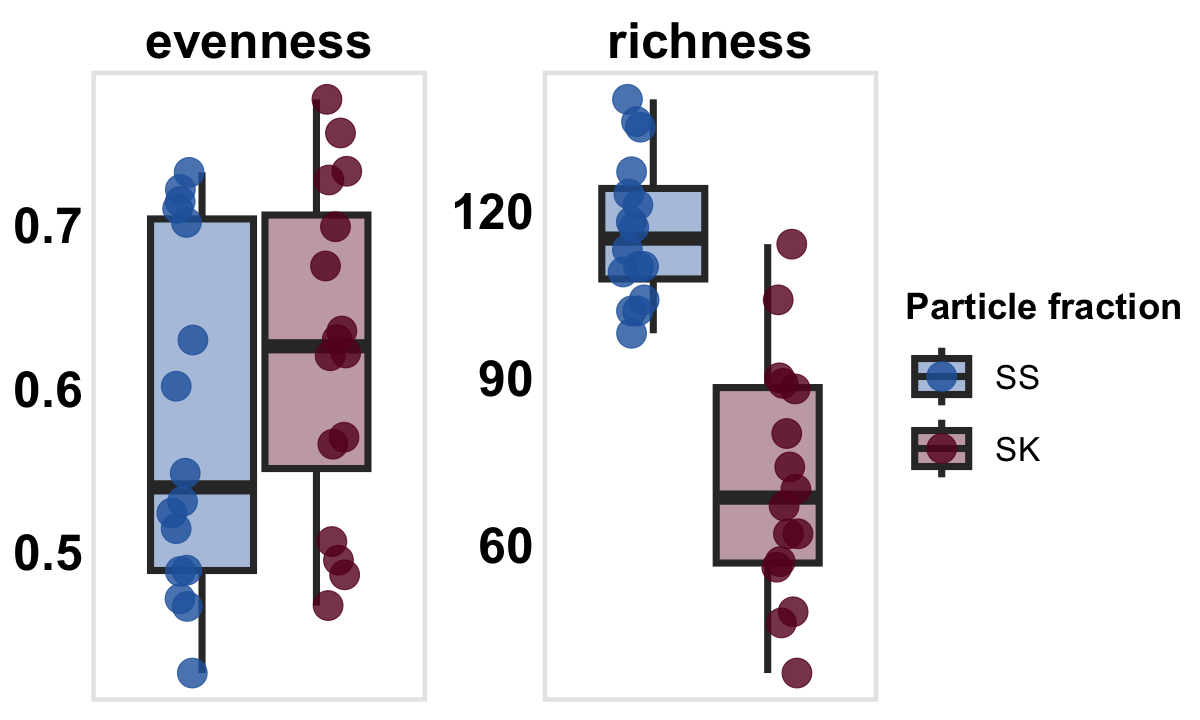

In [ ]:
#All protists Alpha diversity calculation
photo_df <- Oyashio18sMetadata_df %>% filter(PotentialTrophicMode %in% c("Phototroph")) %>%
                                       select(Sample,asvCount,ASVID)%>%
                                       pivot_wider(names_from = Sample,values_from = asvCount) %>%
                                       select(starts_with("A_M")) 
# calculate alpha diversity with vegan
ASV_protist_S = vegan::diversity(t(photo_df),"shannon")
ASV_protist_R = vegan::specnumber(t(photo_df))
ASV_protist_J = ASV_protist_S/log(ASV_protist_R, base=exp(1))

Shannon <- ASV_protist_S %>% as.data.frame()%>% rename("." = "shannon")
Richness <- ASV_protist_R %>% as.data.frame()%>% rename("." = "richness")
Evenness <- ASV_protist_J %>% as.data.frame()%>% rename("." = "evenness")
alpha_df <- cbind(Shannon,Richness,Evenness) %>% 
    rownames_to_column(var = "Sample")%>% # transfer rowname into new column
    pivot_longer(cols = c(shannon,richness,evenness),names_to = "Index",values_to = "value") %>%
    left_join(sample_info_df,by = "Sample")%>%
    filter(Index != "shannon") %>%
    mutate(across(Particle_types,factor, levels=c("SS","SK")))
    
options(repr.plot.width=10, repr.plot.height=6)
pd = ggplot2::position_jitterdodge(dodge.width = 0.75, jitter.width = 0.3, seed = 1)
Fig1 <- ggplot(alpha_df, aes(x=Particle_types,y=value,fill=Particle_types))+
    geom_boxplot(alpha=0.4,width = 1.5,size=2)+
    geom_point(aes(color=Particle_types),size=8,alpha=0.8,position = pd)+
    facet_wrap(~Index, scales = "free_y")+
    theme_linedraw(base_line_size = 0)+
    theme(legend.position="right",
        legend.title=element_text(size=22,face = "bold"),
        legend.text=element_text(size=20),
        legend.key.size = unit(3, "lines"),
        # legend.box.background = element_rect(colour = "black"),
        strip.text.x = element_text(size = 30, colour = "#000000",face="bold"),
        strip.background=element_blank(),
        axis.text.y = element_text(size=30,face = "bold",colour ="#000000"),
        axis.text.x = element_blank(),
        axis.title.x=element_text(size = 0),
        axis.title.y=element_text(size = 0,face="bold",colour ="#000000"),
        panel.spacing.x=unit(1, "lines"),
        panel.border = element_rect(colour = "#e7e7e7",fill = NA,size = 2.5))+
    scale_color_manual(values=c("#2464AB","#660020"))+
    scale_fill_manual(values=c("#2464AB","#660020"))+
    labs(fill="Particle fraction",color="Particle fraction")
Fig1

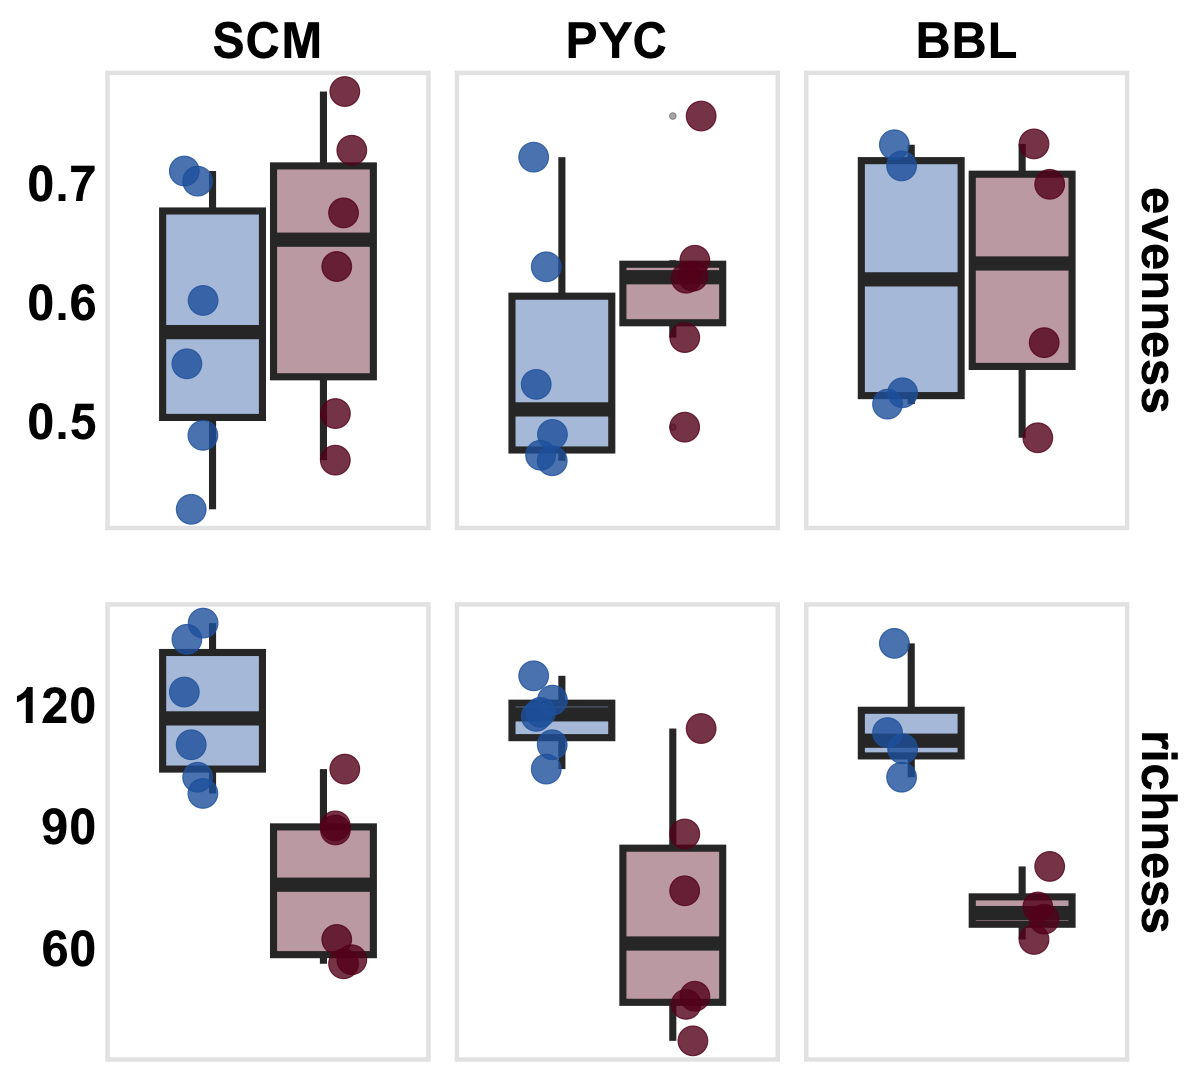

In [ ]:
#All protists Alpha diversity calculation
photo_df <- Oyashio18sMetadata_df %>% filter(PotentialTrophicMode %in% c("Phototroph")) %>%
                                       select(Sample,asvCount,ASVID)%>%
                                       pivot_wider(names_from = Sample,values_from = asvCount) %>%
                                       select(starts_with("A_M")) 
# calculate alpha diversity with vegan
ASV_protist_S = vegan::diversity(t(photo_df),"shannon")
ASV_protist_R = vegan::specnumber(t(photo_df))
ASV_protist_J = ASV_protist_S/log(ASV_protist_R, base=exp(1))

Shannon <- ASV_protist_S %>% as.data.frame()%>% rename("." = "shannon")
Richness <- ASV_protist_R %>% as.data.frame()%>% rename("." = "richness")
Evenness <- ASV_protist_J %>% as.data.frame()%>% rename("." = "evenness")
layers_alpha_df <- cbind(Shannon,Richness,Evenness) %>% 
    rownames_to_column(var = "Sample")%>% # transfer rowname into new column
    pivot_longer(cols = c(shannon,richness,evenness),names_to = "Index",values_to = "value") %>%
    left_join(sample_info_df,by = "Sample")%>%
    filter(Index != "shannon") %>%
    mutate(across(Particle_types,factor, levels=c("SS","SK"))) %>%
    mutate(across(Layers, factor,levels=c("SCM","PYC","BBL")))
    
options(repr.plot.width=10, repr.plot.height=9)
pd = ggplot2::position_jitterdodge(dodge.width = 0.75, jitter.width = 0.3, seed = 1)
Fig1 <- ggplot(layers_alpha_df, aes(x=Particle_types,y=value,fill=Particle_types))+
    geom_boxplot(alpha=0.4,width = 1.5,size=2)+
    geom_point(aes(color=Particle_types),size=8,alpha=0.8,position = pd)+
    facet_grid(Index~Layers, scales = "free")+
    theme_linedraw(base_line_size = 0)+
    theme(legend.position="none",
        strip.text.x = element_text(size = 30, colour = "#000000",face="bold"),
        strip.text.y = element_text(size = 30, colour = "#000000",face="bold"),
        strip.background=element_blank(),
        axis.text.y = element_text(size=30,face = "bold",colour ="#000000"),
        axis.text.x = element_blank(),
        axis.title.x=element_text(size = 0),
        axis.title.y=element_text(size = 0,face="bold",colour ="#000000"),
        panel.spacing.x=unit(1, "lines"),
        panel.spacing.y=unit(3, "lines"),
        panel.border = element_rect(colour = "#e7e7e7",fill = NA,size = 2.5))+
    scale_color_manual(values=c("#2464AB","#660020"))+
    scale_fill_manual(values=c("#2464AB","#660020"))+
    labs(fill="Particle fraction",color="Particle fraction")
Fig1

##### Wilcox test

In [ ]:
# test phytoplankton subsampled
alpha_test_df <- alpha_df%>% select(Sample,Layers,Particle_types,Index,value)%>% 
    pivot_wider(names_from =Index,values_from = value )%>%
    arrange(desc(Sample))
#evenness
Suspended <- subset(alpha_test_df, Particle_types=="SS",evenness,drop=TRUE)
Sinking <- subset(alpha_test_df, Particle_types=="SK",evenness,drop=TRUE)

wilcox_even <- wilcox.test(Suspended, Sinking, paired = TRUE)
wilcox_even
#richness
Suspended <- subset(alpha_test_df, Particle_types=="SS",richness,drop=TRUE)
Sinking <- subset(alpha_test_df, Particle_types=="SK",richness,drop=TRUE)

wilcox_rich <- wilcox.test(Suspended, Sinking, paired = TRUE)
wilcox_rich


	Wilcoxon signed rank exact test

data:  Suspended and Sinking
V = 37, p-value = 0.1167
alternative hypothesis: true location shift is not equal to 0


Warning message in wilcox.test.default(Suspended, Sinking, paired = TRUE):
"cannot compute exact p-value with ties"



	Wilcoxon signed rank test with continuity correction

data:  Suspended and Sinking
V = 134, p-value = 0.0007024
alternative hypothesis: true location shift is not equal to 0


In [ ]:
#SCM
alpha_test_df <- layers_alpha_df%>% select(Sample,Layers,Particle_types,Index,value)%>%
    filter(Layers == "SCM") %>%
    pivot_wider(names_from =Index,values_from = value )%>%
    arrange(desc(Sample))
#evenness
Suspended <- subset(alpha_test_df, Particle_types=="SS",evenness,drop=TRUE)
Sinking <- subset(alpha_test_df, Particle_types=="SK",evenness,drop=TRUE)
wilcox_even <- wilcox.test(Suspended, Sinking, paired = TRUE)
wilcox_even
#richness
Suspended <- subset(alpha_test_df, Particle_types=="SS",richness,drop=TRUE)
Sinking <- subset(alpha_test_df, Particle_types=="SK",richness,drop=TRUE)

wilcox_rich <- wilcox.test(Suspended, Sinking, paired = TRUE)
wilcox_rich


	Wilcoxon signed rank exact test

data:  Suspended and Sinking
V = 4, p-value = 0.2188
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon signed rank exact test

data:  Suspended and Sinking
V = 21, p-value = 0.03125
alternative hypothesis: true location shift is not equal to 0


In [ ]:
#PYC
alpha_test_df <- layers_alpha_df%>% select(Sample,Layers,Particle_types,Index,value)%>%
    filter(Layers == "PYC") %>%
    pivot_wider(names_from =Index,values_from = value )%>%
    arrange(desc(Sample))
#evenness
Suspended <- subset(alpha_test_df, Particle_types=="SS",evenness,drop=TRUE)
Sinking <- subset(alpha_test_df, Particle_types=="SK",evenness,drop=TRUE)
wilcox_even <- wilcox.test(Suspended, Sinking, paired = TRUE)
wilcox_even
#richness
Suspended <- subset(alpha_test_df, Particle_types=="SS",richness,drop=TRUE)
Sinking <- subset(alpha_test_df, Particle_types=="SK",richness,drop=TRUE)

wilcox_rich <- wilcox.test(Suspended, Sinking, paired = TRUE)
wilcox_rich


	Wilcoxon signed rank exact test

data:  Suspended and Sinking
V = 3, p-value = 0.1563
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon signed rank exact test

data:  Suspended and Sinking
V = 20, p-value = 0.0625
alternative hypothesis: true location shift is not equal to 0


In [ ]:
#BBL
alpha_test_df <- layers_alpha_df%>% select(Sample,Layers,Particle_types,Index,value)%>%
    filter(Layers == "BBL") %>%
    pivot_wider(names_from =Index,values_from = value )%>%
    arrange(desc(Sample))
#evenness
Suspended <- subset(alpha_test_df, Particle_types=="SS",evenness,drop=TRUE)
Sinking <- subset(alpha_test_df, Particle_types=="SK",evenness,drop=TRUE)
wilcox_even <- wilcox.test(Suspended, Sinking, paired = TRUE)
wilcox_even
#richness
Suspended <- subset(alpha_test_df, Particle_types=="SS",richness,drop=TRUE)
Sinking <- subset(alpha_test_df, Particle_types=="SK",richness,drop=TRUE)

wilcox_rich <- wilcox.test(Suspended, Sinking, paired = TRUE)
wilcox_rich


	Wilcoxon signed rank exact test

data:  Suspended and Sinking
V = 5, p-value = 1
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon signed rank exact test

data:  Suspended and Sinking
V = 10, p-value = 0.125
alternative hypothesis: true location shift is not equal to 0


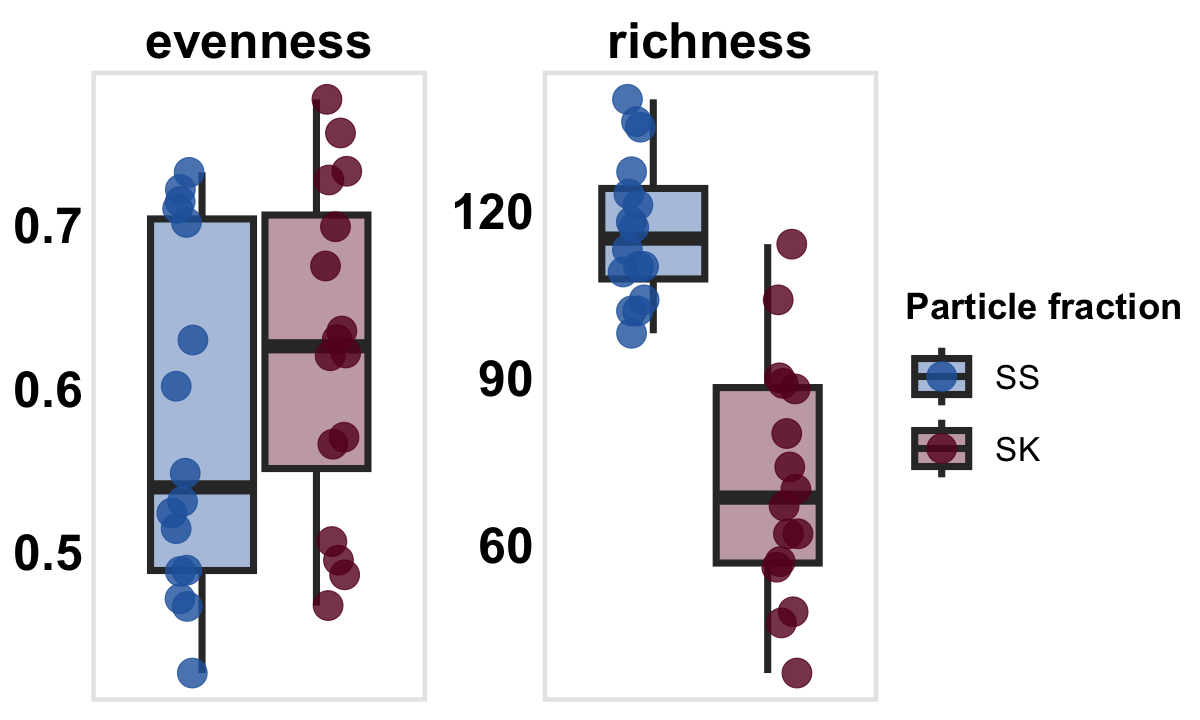

In [45]:
#All protists Alpha diversity calculation
photo_df <- Oyashio18sMetadata_df %>% filter(PotentialTrophicMode %in% c("Phototroph")) %>%
                                       select(Sample,asvCount,ASVID)%>%
                                       pivot_wider(names_from = Sample,values_from = asvCount) %>%
                                       select(starts_with("A_M")) 
# calculate alpha diversity with vegan
ASV_protist_S = vegan::diversity(t(photo_df),"shannon")
ASV_protist_R = vegan::specnumber(t(photo_df))
ASV_protist_J = ASV_protist_S/log(ASV_protist_R, base=exp(1))

Shannon <- ASV_protist_S %>% as.data.frame()%>% rename("." = "shannon")
Richness <- ASV_protist_R %>% as.data.frame()%>% rename("." = "richness")
Evenness <- ASV_protist_J %>% as.data.frame()%>% rename("." = "evenness")
alpha_df <- cbind(Shannon,Richness,Evenness) %>% 
    rownames_to_column(var = "Sample")%>% # transfer rowname into new column
    pivot_longer(cols = c(shannon,richness,evenness),names_to = "Index",values_to = "value") %>%
    left_join(sample_info_df,by = "Sample")%>%
    filter(Index != "shannon") %>%
    mutate(across(Particle_types,factor, levels=c("SS","SK")))
    
options(repr.plot.width=10, repr.plot.height=6)
pd = ggplot2::position_jitterdodge(dodge.width = 0.75, jitter.width = 0.3, seed = 1)
Fig1 <- ggplot(alpha_df, aes(x=Particle_types,y=value,fill=Particle_types))+
    geom_boxplot(alpha=0.4,width = 1.5,size=2)+
    geom_point(aes(color=Particle_types),size=8,alpha=0.8,position = pd)+
    facet_wrap(~Index, scales = "free_y")+
    theme_linedraw(base_line_size = 0)+
    theme(legend.position="right",
        legend.title=element_text(size=22,face = "bold"),
        legend.text=element_text(size=20),
        legend.key.size = unit(3, "lines"),
        # legend.box.background = element_rect(colour = "black"),
        strip.text.x = element_text(size = 30, colour = "#000000",face="bold"),
        strip.background=element_blank(),
        axis.text.y = element_text(size=30,face = "bold",colour ="#000000"),
        axis.text.x = element_blank(),
        axis.title.x=element_text(size = 0),
        axis.title.y=element_text(size = 0,face="bold",colour ="#000000"),
        panel.spacing.x=unit(1, "lines"),
        panel.border = element_rect(colour = "#e7e7e7",fill = NA,size = 2.5))+
    scale_color_manual(values=c("#2464AB","#660020"))+
    scale_fill_manual(values=c("#2464AB","#660020"))+
    labs(fill="Particle fraction",color="Particle fraction")
Fig1

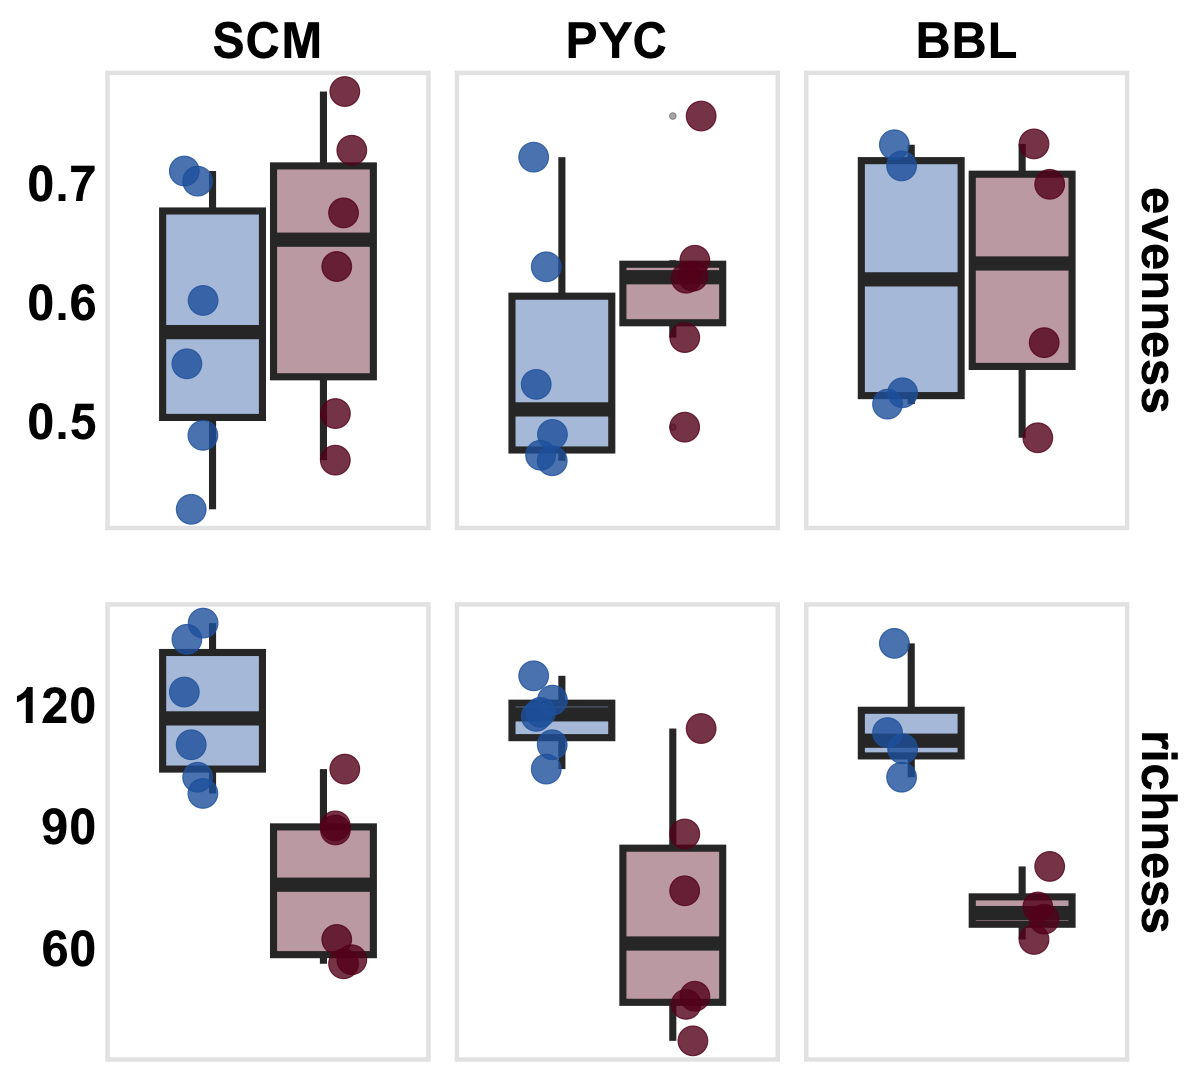

In [48]:
#All protists Alpha diversity calculation
photo_df <- Oyashio18sMetadata_df %>% filter(PotentialTrophicMode %in% c("Phototroph")) %>%
                                       select(Sample,asvCount,ASVID)%>%
                                       pivot_wider(names_from = Sample,values_from = asvCount) %>%
                                       select(starts_with("A_M")) 
# calculate alpha diversity with vegan
ASV_protist_S = vegan::diversity(t(photo_df),"shannon")
ASV_protist_R = vegan::specnumber(t(photo_df))
ASV_protist_J = ASV_protist_S/log(ASV_protist_R, base=exp(1))

Shannon <- ASV_protist_S %>% as.data.frame()%>% rename("." = "shannon")
Richness <- ASV_protist_R %>% as.data.frame()%>% rename("." = "richness")
Evenness <- ASV_protist_J %>% as.data.frame()%>% rename("." = "evenness")
layers_alpha_df <- cbind(Shannon,Richness,Evenness) %>% 
    rownames_to_column(var = "Sample")%>% # transfer rowname into new column
    pivot_longer(cols = c(shannon,richness,evenness),names_to = "Index",values_to = "value") %>%
    left_join(sample_info_df,by = "Sample")%>%
    filter(Index != "shannon") %>%
    mutate(across(Particle_types,factor, levels=c("SS","SK"))) %>%
    mutate(across(Layers, factor,levels=c("SCM","PYC","BBL")))
    
options(repr.plot.width=10, repr.plot.height=9)
pd = ggplot2::position_jitterdodge(dodge.width = 0.75, jitter.width = 0.3, seed = 1)
Fig1 <- ggplot(layers_alpha_df, aes(x=Particle_types,y=value,fill=Particle_types))+
    geom_boxplot(alpha=0.4,width = 1.5,size=2)+
    geom_point(aes(color=Particle_types),size=8,alpha=0.8,position = pd)+
    facet_grid(Index~Layers, scales = "free")+
    theme_linedraw(base_line_size = 0)+
    theme(legend.position="none",
        strip.text.x = element_text(size = 30, colour = "#000000",face="bold"),
        strip.text.y = element_text(size = 30, colour = "#000000",face="bold"),
        strip.background=element_blank(),
        axis.text.y = element_text(size=30,face = "bold",colour ="#000000"),
        axis.text.x = element_blank(),
        axis.title.x=element_text(size = 0),
        axis.title.y=element_text(size = 0,face="bold",colour ="#000000"),
        panel.spacing.x=unit(1, "lines"),
        panel.spacing.y=unit(3, "lines"),
        panel.border = element_rect(colour = "#e7e7e7",fill = NA,size = 2.5))+
    scale_color_manual(values=c("#2464AB","#660020"))+
    scale_fill_manual(values=c("#2464AB","#660020"))+
    labs(fill="Particle fraction",color="Particle fraction")
Fig1

##### Wilcox test

In [49]:
# test phytoplankton subsampled
alpha_test_df <- alpha_df%>% select(Sample,Layers,Particle_types,Index,value)%>% 
    pivot_wider(names_from =Index,values_from = value )%>%
    arrange(desc(Sample))
#evenness
Suspended <- subset(alpha_test_df, Particle_types=="SS",evenness,drop=TRUE)
Sinking <- subset(alpha_test_df, Particle_types=="SK",evenness,drop=TRUE)

wilcox_even <- wilcox.test(Suspended, Sinking, paired = TRUE)
wilcox_even
#richness
Suspended <- subset(alpha_test_df, Particle_types=="SS",richness,drop=TRUE)
Sinking <- subset(alpha_test_df, Particle_types=="SK",richness,drop=TRUE)

wilcox_rich <- wilcox.test(Suspended, Sinking, paired = TRUE)
wilcox_rich


	Wilcoxon signed rank exact test

data:  Suspended and Sinking
V = 37, p-value = 0.1167
alternative hypothesis: true location shift is not equal to 0


Warning message in wilcox.test.default(Suspended, Sinking, paired = TRUE):
"cannot compute exact p-value with ties"



	Wilcoxon signed rank test with continuity correction

data:  Suspended and Sinking
V = 134, p-value = 0.0007024
alternative hypothesis: true location shift is not equal to 0


In [50]:
#SCM
alpha_test_df <- layers_alpha_df%>% select(Sample,Layers,Particle_types,Index,value)%>%
    filter(Layers == "SCM") %>%
    pivot_wider(names_from =Index,values_from = value )%>%
    arrange(desc(Sample))
#evenness
Suspended <- subset(alpha_test_df, Particle_types=="SS",evenness,drop=TRUE)
Sinking <- subset(alpha_test_df, Particle_types=="SK",evenness,drop=TRUE)
wilcox_even <- wilcox.test(Suspended, Sinking, paired = TRUE)
wilcox_even
#richness
Suspended <- subset(alpha_test_df, Particle_types=="SS",richness,drop=TRUE)
Sinking <- subset(alpha_test_df, Particle_types=="SK",richness,drop=TRUE)

wilcox_rich <- wilcox.test(Suspended, Sinking, paired = TRUE)
wilcox_rich


	Wilcoxon signed rank exact test

data:  Suspended and Sinking
V = 4, p-value = 0.2188
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon signed rank exact test

data:  Suspended and Sinking
V = 21, p-value = 0.03125
alternative hypothesis: true location shift is not equal to 0


In [51]:
#PYC
alpha_test_df <- layers_alpha_df%>% select(Sample,Layers,Particle_types,Index,value)%>%
    filter(Layers == "PYC") %>%
    pivot_wider(names_from =Index,values_from = value )%>%
    arrange(desc(Sample))
#evenness
Suspended <- subset(alpha_test_df, Particle_types=="SS",evenness,drop=TRUE)
Sinking <- subset(alpha_test_df, Particle_types=="SK",evenness,drop=TRUE)
wilcox_even <- wilcox.test(Suspended, Sinking, paired = TRUE)
wilcox_even
#richness
Suspended <- subset(alpha_test_df, Particle_types=="SS",richness,drop=TRUE)
Sinking <- subset(alpha_test_df, Particle_types=="SK",richness,drop=TRUE)

wilcox_rich <- wilcox.test(Suspended, Sinking, paired = TRUE)
wilcox_rich


	Wilcoxon signed rank exact test

data:  Suspended and Sinking
V = 3, p-value = 0.1563
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon signed rank exact test

data:  Suspended and Sinking
V = 20, p-value = 0.0625
alternative hypothesis: true location shift is not equal to 0


In [52]:
#BBL
alpha_test_df <- layers_alpha_df%>% select(Sample,Layers,Particle_types,Index,value)%>%
    filter(Layers == "BBL") %>%
    pivot_wider(names_from =Index,values_from = value )%>%
    arrange(desc(Sample))
#evenness
Suspended <- subset(alpha_test_df, Particle_types=="SS",evenness,drop=TRUE)
Sinking <- subset(alpha_test_df, Particle_types=="SK",evenness,drop=TRUE)
wilcox_even <- wilcox.test(Suspended, Sinking, paired = TRUE)
wilcox_even
#richness
Suspended <- subset(alpha_test_df, Particle_types=="SS",richness,drop=TRUE)
Sinking <- subset(alpha_test_df, Particle_types=="SK",richness,drop=TRUE)

wilcox_rich <- wilcox.test(Suspended, Sinking, paired = TRUE)
wilcox_rich


	Wilcoxon signed rank exact test

data:  Suspended and Sinking
V = 5, p-value = 1
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon signed rank exact test

data:  Suspended and Sinking
V = 10, p-value = 0.125
alternative hypothesis: true location shift is not equal to 0


### Trophic Mode composition

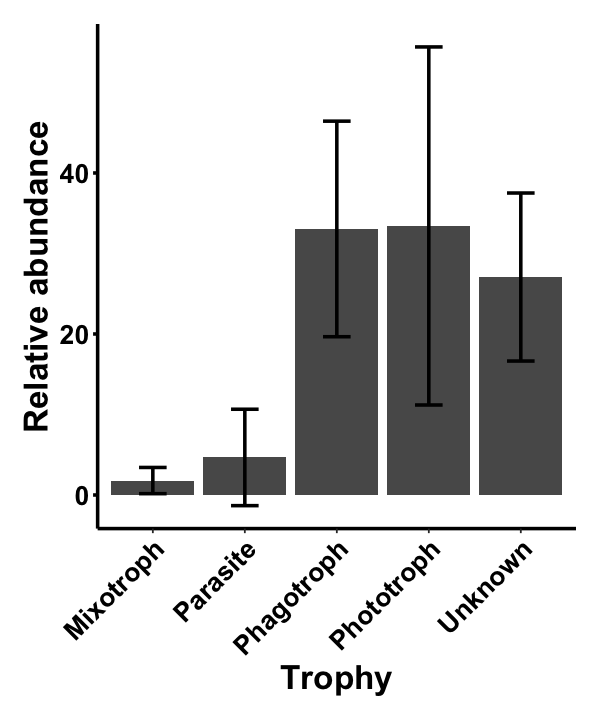

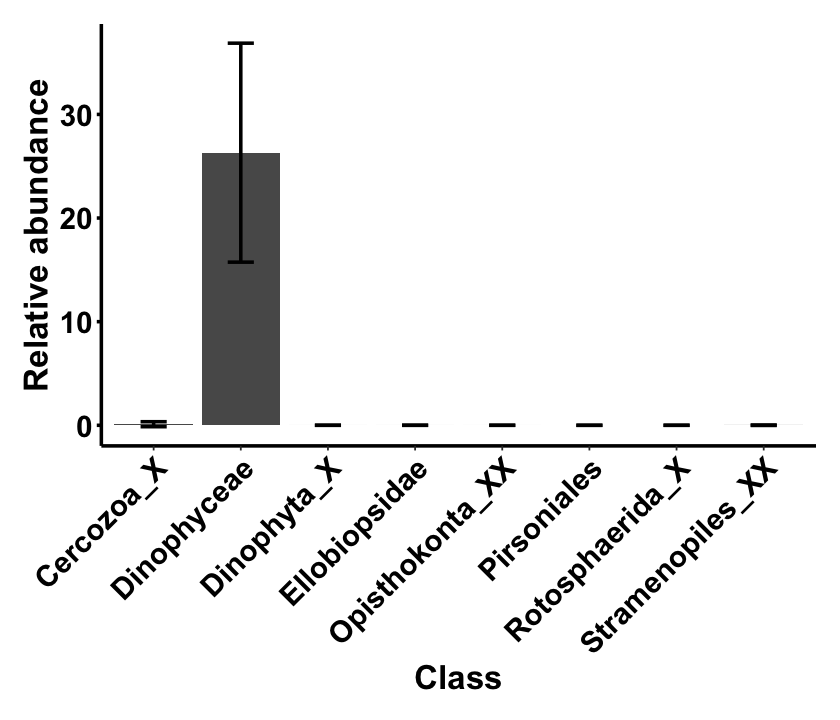

In [17]:
# colnames(Oyashio18sMetadata_df)
options(repr.plot.width=5, repr.plot.height=6)

data_summary <- function(data, varname, groupnames){
  require(plyr)
  summary_func <- function(x, col){
    c(mean = mean(x[[col]], na.rm=TRUE),
      sd = sd(x[[col]], na.rm=TRUE))
  }
  data_sum<-ddply(data, groupnames, .fun=summary_func,
                  varname)
  data_sum <- rename(data_sum, c("mean" = varname))
 return(data_sum)
}


trophic_df <- Oyashio18sMetadata_df %>% select(Sample,PotentialTrophicMode,asvCount)%>% group_by(Sample,PotentialTrophicMode)%>%dplyr::summarise(sumMode=sum(asvCount)/337.62,.groups = "drop") 

df3 <- data_summary(trophic_df, varname="sumMode", 
                    groupnames=c("PotentialTrophicMode"))%>%
                    mutate(across(PotentialTrophicMode,factor,levels=c("Phototroph","Phagotroph","Parasite","Mixotroph","Unknown")))
p <- ggplot(df3, aes(x=PotentialTrophicMode, y=sumMode))+
      geom_bar(stat="identity", position=position_dodge())+
      geom_errorbar(aes(ymin=sumMode-sd, ymax=sumMode+sd),width=0.3, position = position_dodge(0.9),linewidth = 1)+
      labs(x="Trophy",y="Relative abundance")+
      theme_classic()+
      theme(plot.margin=unit(c(1,1,1,1), units="line"),
            axis.text.x = element_text(size=16,face = "bold",angle=45,colour ="#000000",vjust=1,hjust=1),
            axis.text.y=element_text(size = 16,face="bold",colour ="#000000"),
            axis.title.x=element_text(size = 20,face="bold",colour ="#000000"),
            axis.title.y=element_text(size = 20,face="bold",colour ="#000000"),
            axis.line.y = element_line(color="#000000", linewidth = 1),
            axis.line.x = element_line(color="#000000", linewidth = 1),
            axis.ticks.y = element_line(color ="#000000",linewidth = 1),
            panel.spacing.x=unit(0.5, "lines"),
            panel.spacing.y=unit(0.5, "lines"))
p

unknown_trophic_df <- Oyashio18sMetadata_df %>% filter(PotentialTrophicMode=="Unknown") %>%
                                    group_by(Sample,Class)%>% 
                                    dplyr::summarise(sumMode=sum(asvCount)/337.62,.groups="drop")%>%
                                    filter(Class != "unassigned")
options(repr.plot.width=7, repr.plot.height=6)
df4 <- data_summary(unknown_trophic_df, varname="sumMode", 
                    groupnames=c("Class"))#%>%
                  #   mutate(across(PotentialTrophicMode,factor,levels=c("Phototroph","Phagotroph","Parasite","Mixotroph","Unknown")))
ggplot(df4, aes(x=Class, y=sumMode))+
      geom_bar(stat="identity", position=position_dodge())+
      geom_errorbar(aes(ymin=sumMode-sd, ymax=sumMode+sd),width=0.3, position = position_dodge(0.9),linewidth = 1)+
      labs(x="Class",y="Relative abundance")+
      theme_classic()+
      theme(plot.margin=unit(c(1,1,1,1), units="line"),
            axis.text.x = element_text(size=18,face = "bold",angle=45,colour ="#000000",vjust=1,hjust=1),
            axis.text.y=element_text(size = 18,face="bold",colour ="#000000"),
            axis.title.x=element_text(size = 20,face="bold",colour ="#000000"),
            axis.title.y=element_text(size = 20,face="bold",colour ="#000000"),
            axis.line.y = element_line(color="#000000", linewidth = 1),
            axis.line.x = element_line(color="#000000", linewidth = 1),
            axis.ticks.y = element_line(color ="#000000",linewidth = 1),
            panel.spacing.x=unit(0.5, "lines"),
            panel.spacing.y=unit(0.5, "lines"))

### PartIV-I Heatmap of community compositionm
- Heatmap was generate by phython script with name python-plot.ipynb
- The dataframe input into the python-plot.ipynb is prepare with following code

#### Class Level

In [ ]:
#Class
sum(Oyashio18sMetadata_df$asvCount)/32 * 0.001
class_df <- Oyashio18sMetadata_df %>%
                    filter(Group!="ungrouped") %>%
                    unite(re_class, Division, Class, sep="|") %>%
                    select(re_class,Sample,asvCount) %>%
                    group_by(Sample,re_class) %>%
                    summarise(sumClass=sum(asvCount),.groups="drop") %>%
                    filter(sumClass>=337.62)

select_class <- (unique(class_df$re_class))

select_class_df1 <- Oyashio18sMetadata_df %>%
                    filter(Group!="ungrouped")%>%
                    unite(re_class, Division, Class, sep="|") %>%
                    filter(re_class %in% select_class) %>%
                    unite(class,Group,re_class,sep = ":")%>%
                    group_by(class,Particle_types,Station,Layers) %>%
                    summarise(sumClass=sum(asvCount),.groups="drop") 

# Define the unique classes, stations, and particle types
unique_classes <- select_class_df1$class
stations <- c("St1_May", "St2_May")
particle_types <- c("SS", "SK")

# Create the full combination dataframe
Fill_df <- crossing(class = unique_classes, 
                    Station = stations, 
                    Particle_types = particle_types, 
                    Layers = "BBL") %>%
            mutate(sumClass = 0)

select_class_df <- rbind(select_class_df1,Fill_df)

write.csv(select_class_df,file.path(Process_path,"1_heatmap_class.csv"),row.names=FALSE)

[1] 33.762

#### Diatom

In [10]:
select_diatom_df <- Oyashio18sMetadata_df %>% 
            filter(Class %in% c("Mediophyceae"))%>% #,"Bacillariophyceae","Coscinodiscophyceae"
            filter(Genus != "unassigned" | Order!="unassigned") %>%
            tidyr::unite(re_genus,Order, Genus, sep="|")%>%
            group_by(re_genus,Sample)%>%
            summarise(sumGenus=sum(asvCount),.groups="drop") %>%
            filter(sumGenus >= 337.62)
select_diatom <- unique(select_diatom_df$re_genus)

diatom_df1 <- Oyashio18sMetadata_df %>% 
            filter(Class %in% c("Mediophyceae"))%>% #,"Bacillariophyceae","Coscinodiscophyceae"
            tidyr::unite(genus, Order, Genus, sep="|",remove = FALSE)%>%
            filter(genus %in% select_diatom)%>%
            group_by(genus,Particle_types,Station,Layers) %>%
            summarise(sumGenus=sum(asvCount),.groups="drop")
        
# Define the unique classes, stations, and particle types
unique_genus <- diatom_df1$genus
stations <- c("St1_May", "St2_May")
particle_types <- c("SS", "SK")

# Create the full combination dataframe
Fill_df <- crossing(genus = unique_genus, 
                    Station = stations, 
                    Particle_types = particle_types, 
                    Layers = "BBL") %>%
            mutate(sumGenus = 0)

diatom_df <- rbind(diatom_df1,Fill_df)

write.csv(diatom_df,file.path(Process_path,"2_heatmap_diatom_genus.csv"),row.names=FALSE)


#### Dinoflagellata

In [6]:
select_dino_df <- Oyashio18sMetadata_df %>% 
            filter(Class %in% c("Dinophyceae"))%>% #Subdivision %in% c("Dinoflagellata"
            filter(Genus != "unassigned" | Order!="unassigned") %>%
            tidyr::unite(re_genus,Order, Genus, sep="|")%>%
            group_by(re_genus,Sample)%>%
            summarise(sumGenus=sum(asvCount),.groups="drop") %>%
            filter(sumGenus >= 337.62)
select_dino <- unique(select_dino_df$re_genus)

dino_df1 <- Oyashio18sMetadata_df %>% 
            filter(Subdivision %in% c("Dinoflagellata"))%>%
            tidyr::unite(re_genus, Order, Genus, sep="|",remove = FALSE)%>%
            filter(re_genus %in% select_dino)%>%
            mutate(genus=case_when(Genus %in% c("unassigned")  ~ "others",
                                   TRUE ~ re_genus))%>%
            group_by(genus,Particle_types,Station,Layers) %>%
            summarise(sumGenus=sum(asvCount),.groups="drop")
        
# Define the unique classes, stations, and particle types
unique_genus <- dino_df1$genus
stations <- c("St1_May", "St2_May")
particle_types <- c("SS", "SK")

# Create the full combination dataframe
Fill_df <- crossing(genus = unique_genus, 
                    Station = stations, 
                    Particle_types = particle_types, 
                    Layers = "BBL") %>%
            mutate(sumGenus = 0)

dino_df <- rbind(dino_df1,Fill_df)

write.csv(dino_df,file.path(Process_path,"2_heatmap_dino_genus.csv"),row.names=FALSE)

### PartIV-III SourceTracker

In [8]:
source("/Users/yangqingwei/Library/CloudStorage/OneDrive-KyotoUniversity/Oya18S/01-script/sourcetracker-master/src/SourceTracker.r")

- SCM-SK, PYC-SS-,BBL-SS -> Source
- BBL-SK -> sink


In [389]:
downstream_all_bblsk <- data.frame(
  Source = character(),
  Proportion = numeric(),
  Station = character(),
  stringsAsFactors = FALSE  # This ensures that character columns are not converted to factors
)

Oyashio18sMetadata_df <- read.csv("/Users/yangqingwei/Library/CloudStorage/OneDrive-KyotoUniversity/Oya18S/02_proce/0_oyashio18smetadata.csv")

Station <- unique(Oyashio18sMetadata_df$Station)
Station <- Station[!(Station %in% c("St2_May", "St1_May"))]
for (station in Station){
    # read in ASV table
    metadata <- Oyashio18sMetadata_df%>%filter(!(Particle_types %in% c("SK") & Layers %in% c("PYC")))%>%
                                        filter(!(Particle_types %in% c("SS") & Layers %in% c("SCM")))%>%
                                        filter(Station %in% c(station)) %>%
                                        tidyr::unite(catego,Layers,Particle_types,sep="_", remove=TRUE)%>%
                                        select(Sample,catego,Station) %>% 
                                        distinct() %>%
                                        mutate(Source=case_when(catego %in% c("BBL_SS","PYC_SS","SCM_SK") ~ "source", TRUE ~"sink"))%>% #,"SCM_SS"
                                        as.data.frame()                             
    rownames(metadata) <- metadata[,1]
    metadata <- metadata[,-1]
    # metadata
    asv.table <- Oyashio18sMetadata_df %>%
                                        filter(PotentialTrophicMode %in% c("Phagotroph","Parasite")) %>% #modify "Parasite"
                                        filter(!(Particle_types %in% c("SK") & Layers %in% c("PYC")))%>%
                                        filter(!(Particle_types %in% c("SS") & Layers %in% c("SCM")))%>%
                                        filter(Station %in% station) %>%
                                        select(ASVID,asvCount,Sample)%>%
                                        pivot_wider(names_from =Sample,values_from = asvCount) %>%
                                        as.data.frame()
    rownames(asv.table) <- asv.table[,1]
    asv.table <- asv.table[,-1]
    # Replace single values with 0
    asv.table[asv.table==1] <- 0
    # Drop ASVs that are now all zeros
    asv.table <- asv.table[which(rowSums(asv.table)>0),]
    # asv.table 

    tax.table <-Oyashio18sMetadata_df%>%filter(PotentialTrophicMode %in% c("Phagotroph","Parasite")) %>%
                                        filter(!(Particle_types %in% c("SK") & Layers %in% c("PYC")))%>%
                                        filter(!(Particle_types %in% c("SS") & Layers %in% c("SCM")))%>%
                                        select(ASVID,Supergroup,Division,Subdivision,Class,Order,Family,Genus,Species)%>% 
                                        distinct()%>%
                                        as.data.frame()
    rownames(tax.table) <- tax.table[,1]
    tax.table <- tax.table[,-1]

    test.physeq <- merge_phyloseq(otu_table(asv.table, taxa_are_rows=TRUE), tax_table(as.matrix(tax.table)), sample_data(metadata))


    asv <- data.frame(otu_table(test.physeq))
    metadata <- data.frame(sample_data(test.physeq))
    t.asv <- t(as.matrix(asv))

    train.ix <- which(metadata$Source=='source')
    test.ix <- which(metadata$Source=='sink')

    envs <- metadata$catego
    desc <- metadata$catego

    st <- sourcetracker(t.asv[train.ix,], envs[train.ix])

    results <- predict(st,t.asv[test.ix,])
    downstream <- results$proportions %>%as.data.frame() %>%
                pivot_longer(cols=c("BBL_SS","PYC_SS","SCM_SK","Unknown"),names_to="Source",values_to="Proportion")%>% #,"SCM_SS"
                mutate(Station=station)
    downstream_all_bblsk <- rbind(downstream_all_bblsk,downstream)
}

Rarefying training data at 1000
                                           BBL_SS	     PYC_SS	     SCM_SK	    Unknown
..........   1 of    1, depth= 1000:  0.01 (0.00)	0.01 (0.01)	0.86 (0.00)	0.11 (0.01)
Rarefying training data at 1000
                                           BBL_SS	     PYC_SS	     SCM_SK	    Unknown
..........   1 of    1, depth= 1000:  0.32 (0.02)	0.04 (0.02)	0.45 (0.03)	0.18 (0.01)
Rarefying training data at 1000
                                           BBL_SS	     PYC_SS	     SCM_SK	    Unknown
..........   1 of    1, depth= 1000:  0.08 (0.01)	0.01 (0.00)	0.80 (0.01)	0.10 (0.01)
Rarefying training data at 1000
                                           BBL_SS	     PYC_SS	     SCM_SK	    Unknown
..........   1 of    1, depth= 1000:  0.02 (0.01)	0.02 (0.01)	0.89 (0.01)	0.08 (0.00)


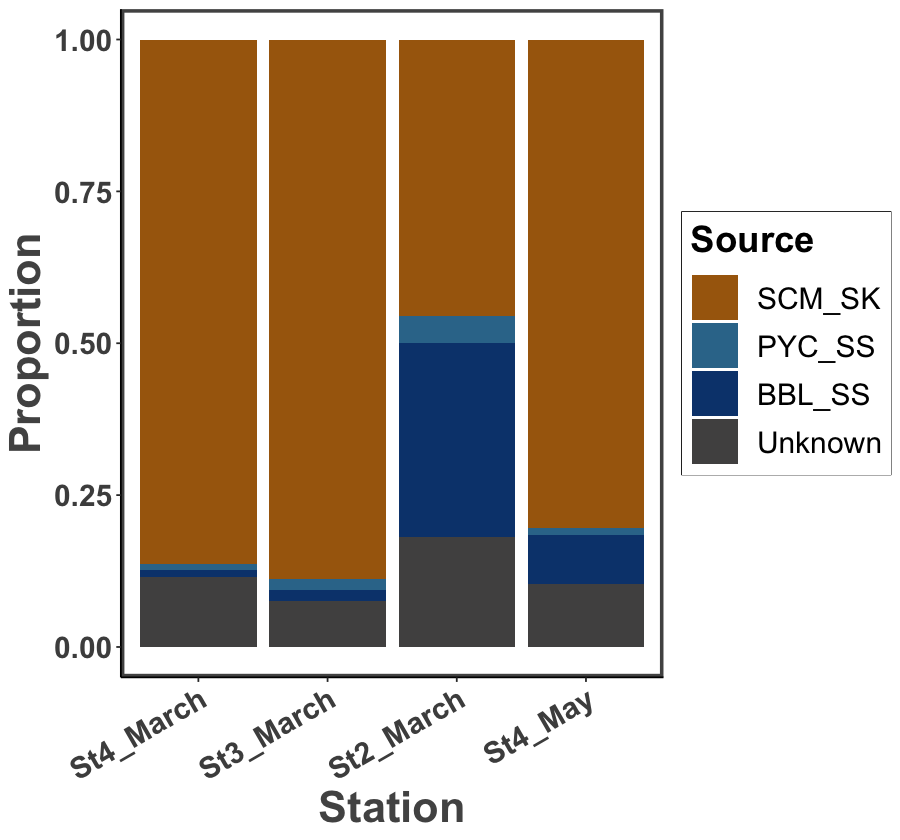

In [390]:
df <- downstream_all_bblsk %>% 
                            mutate(across(Station,factor, levels=c("St4_March","St3_March","St2_March","St4_May")))%>%
                            mutate(across(Source,factor, levels=c("SCM_SK","PYC_SS","BBL_SS","Unknown"))) #,"SCM_SS"
options(repr.plot.width=7.5, repr.plot.height=7)
ggplot(df, aes(x=Station, y=Proportion, fill=Source)) + geom_bar(stat="identity") +
    theme_classic()+
    scale_fill_manual(values=c("#a8670d","#347699", "#0a437c", "#515050"))+ #"#e9b874",
    theme(legend.position="right",
          legend.title=element_text(size=22,face = "bold"),
          legend.text=element_text(size=18),
          legend.key.size = unit(2, "lines"),
          legend.box.background = element_rect(colour = "black"),
          axis.text.y = element_text(size=18,face = "bold"),
          axis.text.x = element_text(size=18,face = "bold",angle = 30,vjust=1,hjust = 1),
          axis.title.x=element_text(size = 26,face="bold",colour ="#525252"),
          axis.title.y=element_text(size = 26,face="bold",colour ="#525252"),
          panel.spacing.x=unit(0.7, "lines"),
          panel.border = element_rect(colour = "#525252",fill = NA,size = 2))

### PartIV-IV Volcano plot for each taxon group

#### Genus Level

##### Filled with taxon (class level)

Warning message:
"Setting row names on a tibble is deprecated."
using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 4 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



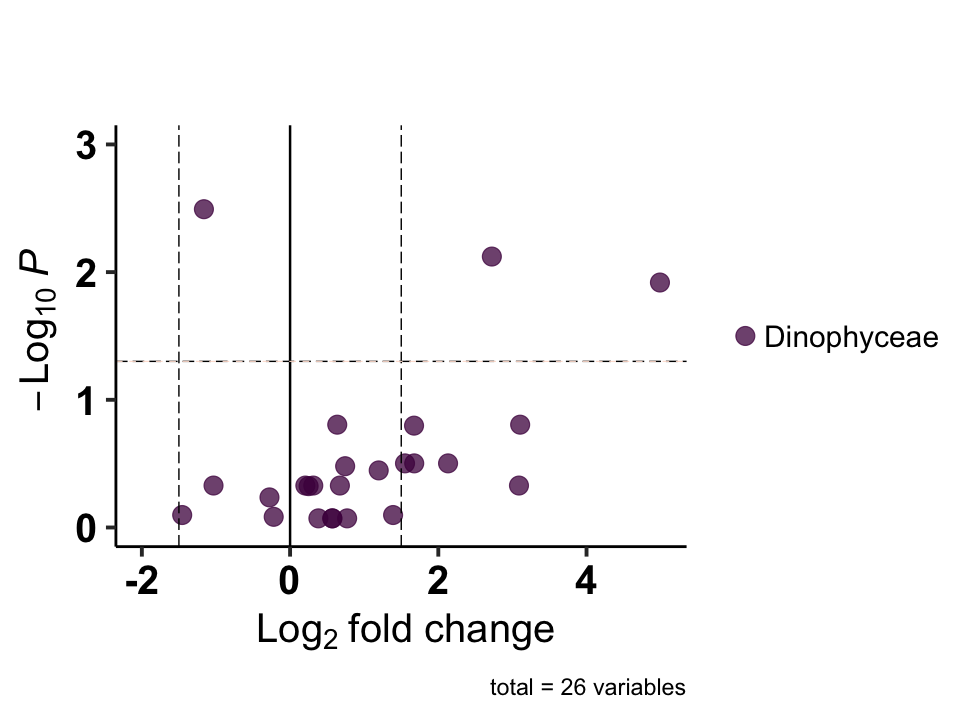

In [40]:
df_class <- Oyashio18sMetadata_df %>%
                          mutate(Re_Class=case_when(grepl("MAST-",Genus) ~ "MASTs",TRUE ~ Class))%>% #Add MASTs group and rename Class
                          select(Sample,Supergroup,Division,Subdivision,Re_Class,asvCount)%>%
                          group_by(Sample,Supergroup,Division,Subdivision,Re_Class) %>%
                          dplyr::summarise(abundance_class=sum(asvCount),.groups = "drop")%>%
                          pivot_wider(names_from = Sample,values_from =abundance_class)%>%
                          mutate(allsum = rowSums(select(., starts_with('A_M')), na.rm = TRUE)/32/337.62)%>%
                          filter(!Re_Class %in% c("unassigned","Gyrista_X","Ciliophora_X","Cercozoa_X") & allsum > 0.2)
  major_class <- df_class$Re_Class

df <- Oyashio18sMetadata_df %>%
        mutate(Re_Class=case_when(grepl("MAST-",Genus) ~ "MASTs",TRUE ~ Class))%>%
        dplyr::filter(PotentialTrophicMode %in% c("Unknown") & Re_Class %in% major_class) %>%  #%in% c("Phagotroph","Parasite") c("Unknown","Mixotroph") c("Phototroph") c("Mixotroph")
        select(ASVID,Supergroup,Division,Subdivision,Re_Class,Order,Family,Genus,Species,asvCount,Sample,Station,Layers)%>%
        # filter(Layers == "SCM") %>%
        arrange(desc(Sample))%>%
        pivot_wider(names_from = Sample,values_from = asvCount) %>%
        group_by(Supergroup,Division,Subdivision,Re_Class,Order,Family,Genus) %>%
        dplyr::summarise(across(where(is.numeric), sum, na.rm = TRUE), .groups = "drop") %>%
        tidyr::unite(rename_genus,Re_Class,Order,Family,Genus, sep=";", remove = FALSE) %>%
        select(rename_genus,Supergroup,Division,Subdivision,Re_Class,Order,Family,Genus,starts_with("A"))%>%
        filter(rowSums(.[,9:40]) != 0) #9:40
        
counts <- df %>% select(rename_genus,starts_with("A"))%>% as.data.frame() 
taxa_df <- df %>% select(1:8) %>% as.data.frame() 
rownames(counts) <- counts$rename_genus 
counts$rename_genus <- NULL
rownames(taxa_df) <- taxa_df$rename_genus
taxa_df$rename_genus <- NULL
samples <-  Oyashio18sMetadata_df %>% 
            select(Sample,Particle_types,Station,Layers) %>%
            # filter(Layers == "SCM") %>%
            distinct()%>%
            arrange(desc(Sample))
rownames(samples) <- samples$Sample
samples$Sample <-NULL

if (any(colnames(counts) !=rownames(samples))){
  counts <- counts[ rownames(taxa_df), ]
  }
counts <- as.matrix(counts)
assays <-  SimpleList(counts = counts)
colData <- DataFrame(colData)
rowData <- DataFrame(rowData)
tse <- TreeSummarizedExperiment(assays = assays,
                                colData = samples,
                                rowData = taxa_df)
                  
tse$Particle_types <- factor(tse$Particle_types)
tse$Particle_types <- relevel(tse$Particle_types, ref = "SS")

# Run DESeq analysis
dssFull <- DESeqDataSet(tse, design = ~Particle_types)
dds <- estimateSizeFactors(dssFull) #geoMeans = ifelse(rowSums(counts(dssFull)) > 0, exp(rowMeans(log(counts(dssFull) + 1))), 1)
dds <- DESeq(dds) #test = "Wald", fitType = "parametric“
res <- results(dds)
  

# Define colors
unique_class <- unique((rowData(tse)%>%as.data.frame())$Re_Class)
class_rownames <- list()
for (class in unique_class) {
  class_rows <- rowData(tse) %>% 
                  as.data.frame() %>% 
                  filter(Re_Class == class) %>% 
                  rownames()
  class_rownames[[class]] <- class_rows
  }

# color_list=c("#05998a", "#053975","#0ca7c6", "#6e7176","#8ecb9e", "#519263","#065105", "#3776ec","#7872f0")
# color_list=c("#08306b", "#41b6c4","#00441b", "#74c476","#993404", "#4d004b","#737373", "#225ea8","#66c2a4", "#b2df8a","#bdbdbd","#238b45","#1c9099")
# color_list=c("#7bccc4", "#084081","#00441b", "#4d004b","#6a51a3", "#bdbdbd")
color_list=c("#4d004b")
keyvals.colour <- rep("#cccccc", nrow(res))

for (i in seq_along(unique_class)) {
  # Assign color to rows that match the current class' row names
  keyvals.colour[rownames(res) %in% class_rownames[[unique_class[i]]]] <- color_list[i]
  }
  names(keyvals.colour) <- unique_class[match(keyvals.colour, color_list)]

options(repr.plot.width=8,repr.plot.height=6)

EnhancedVolcano(res,
                lab = NA,
                # lab = rownames(res),
                x = 'log2FoldChange',
                y = 'padj',
                xlim = c(-2,5), #c(-8,5)  c(-5,8),c(-4,6)
                ylim = c(0,3),  #c(0,6)  c(0,23),c(0,3)
                title = "",
                subtitle = "",
                pCutoff = 0.05,
                FCcutoff = 1.5,
                pointSize = 5, #c(ifelse(g2$res_result$pvalue > 0.05, 3, 6)) #log2((data$res_result$baseMean+1))
                colAlpha = 0.75,
                colCustom = keyvals.colour,         
                gridlines.major = FALSE,
                gridlines.minor = FALSE,
                legendPosition = "right") +
  theme(plot.subtitle = element_text(color = "#000000", size = 24, face = "bold"),
        axis.text.x = element_text(size = 24,face="bold",colour ="#000000"),
        axis.text.y = element_text(size = 24,face="bold",colour ="#000000"),
        axis.title.x = element_text(size = 24,face="bold",colour ="#000000"),
        axis.title.y = element_text(size = 24,face="bold",colour ="#000000"),
        legend.title=element_text(size=0),
        legend.text=element_text(size=18,colour ="#000000"),
        legend.key.size = unit(0.8,"cm"),
        legend.margin=margin(0,1,0,0))+
  geom_vline(xintercept = 0, color = "#000000", linetype = "solid",size=0.7)+
  geom_hline(yintercept = -log10(0.05), color = "#fee0d2", linetype = "dashed",size=0.3)





### PartIV-V Vertical Succession

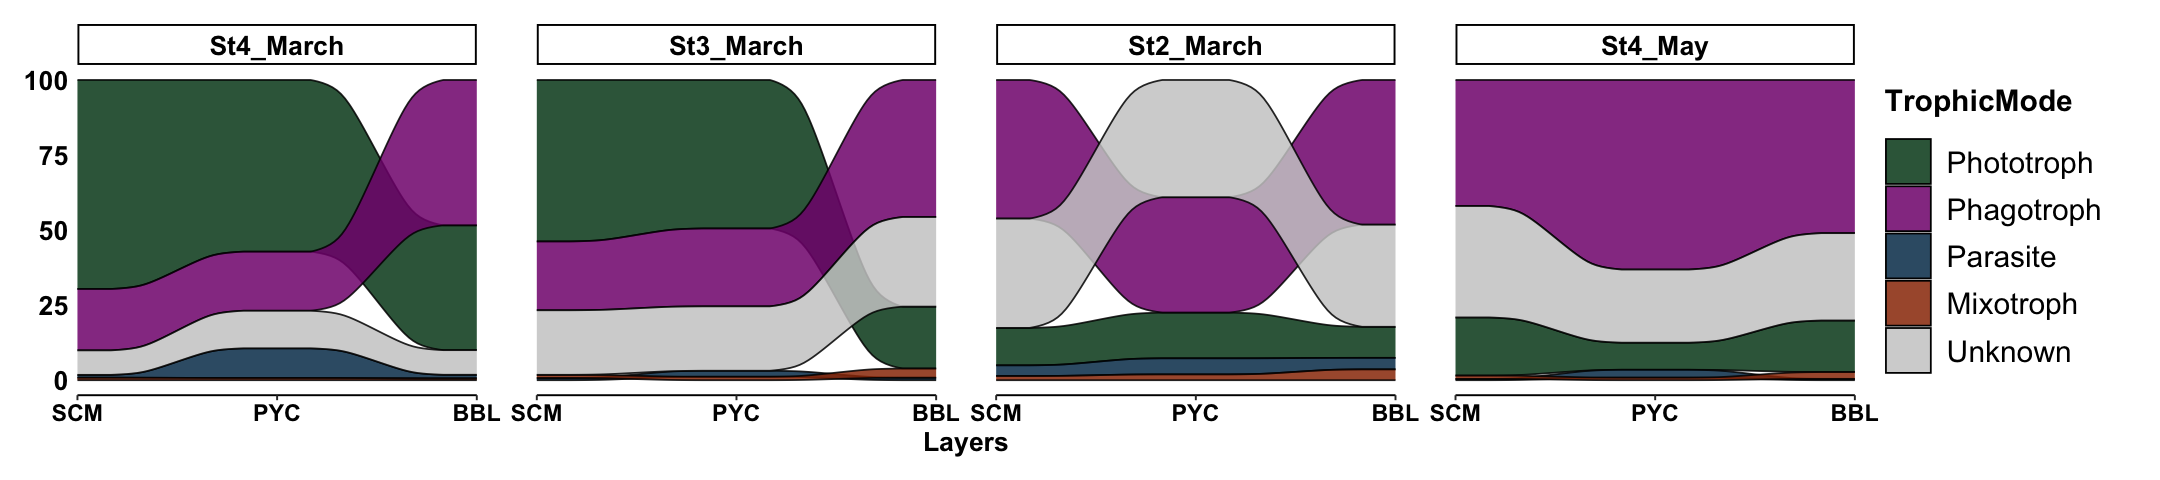

In [39]:
all_df <- Oyashio18sMetadata_df %>%
                            filter(Station %in% c("St2_March","St3_March","St4_March","St4_May"))%>%
                            filter(Particle_types=="SK" )%>% #& Class != "unassigned"
                            # tidyr::unite(Re_Class,PotentialTrophicMode,Class,sep="|", remove = FALSE) %>% 
                            group_by(Station, Sample,Layers,PotentialTrophicMode)%>%
                            summarise(trophic_ab = sum(asvCount)/337.62,.groups = "drop")%>%
                            mutate(across(Layers, factor, levels=c("SCM","PYC","BBL"))) %>%
                            mutate(across(Station, factor, levels=c("St4_March","St3_March","St2_March","St4_May"))) %>%
                            mutate(across(PotentialTrophicMode,factor,levels=c("Phototroph","Phagotroph","Parasite","Mixotroph","Unknown")))
                    
# unique(all_df$Re_Class)
options(repr.plot.width=18, repr.plot.height=4)
ggplot(all_df, aes( x = Layers, y = trophic_ab, alluvium = PotentialTrophicMode)) + 
    geom_alluvium(aes(fill = PotentialTrophicMode), colour = "black", alpha = 0.85, decreasing = FALSE,)+
    facet_wrap(~factor(Station),ncol = 4)+
    ggpubr::theme_classic2()+
    coord_cartesian(ylim =  c(0,100))+
    scale_x_discrete(expand = c(0, 0)) +
    scale_fill_manual(name = "TrophicMode",values=c("#00441b","#810f7c","#023858","#993404","#cccccc"))+
    theme(legend.position="right",
          legend.title=element_text(size=18,face = "bold",colour = "#000000"),
          legend.text=element_text(size=18,colour = "#000000"),
          legend.key.size = unit(1,"cm"),
          plot.margin=unit(c(1,2,1,1), units="line"),
        #   legend.margin=margin(0,0,0,-0.2),
          legend.spacing.y  = unit(0.5, 'cm'),
          strip.text.x = element_text(size = 16, colour = "#000000",face="bold"),
          axis.text.x = element_text(size=14,face = "bold",colour ="#000000"),
          axis.text.y=element_text(size=16,face = "bold",colour ="#000000"),
          axis.title.x=element_text(size = 16,face="bold",colour ="#000000"),
          axis.title.y=element_blank(),
          axis.line.y = element_line(color="white", linewidth = 0),
          axis.ticks.y = element_line(color = "white",linewidth = 0),
          panel.spacing.x=unit(2.5, "lines"))
          # guides(fill = guide_legend(title.position = "top", ncol = 4))       

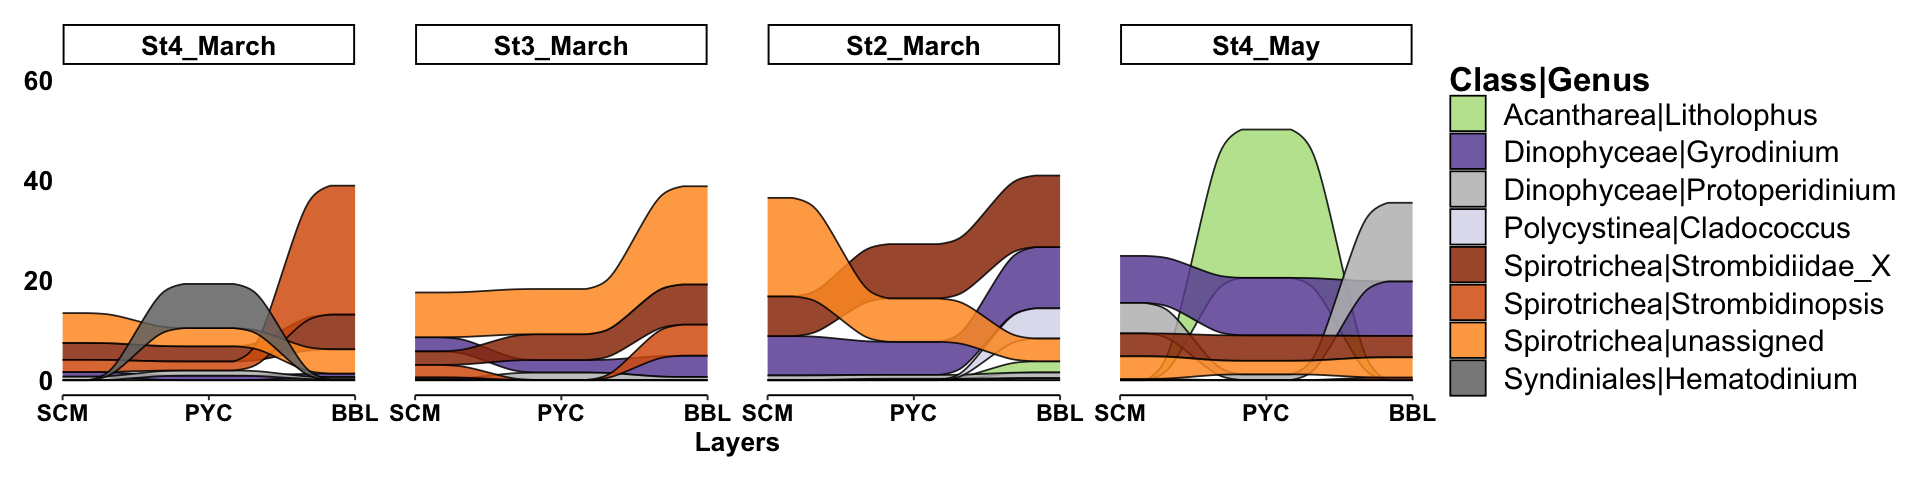

In [43]:


phago_df <- Oyashio18sMetadata_df %>%
                            filter(Station %in% c("St2_March","St3_March","St4_March","St4_May"))%>%
                            filter(Particle_types=="SK" & PotentialTrophicMode  %in% c("Phagotroph","Parasite"))%>%
                            group_by(Station,Sample,Layers,Class,Genus)%>%
                            summarise(genus_ab = sum(asvCount)/337.62,.groups = "drop")%>%
                            tidyr::unite(re_genus,Class,Genus,sep="|", remove = FALSE) %>% 
                            mutate(across(Layers, factor, levels=c("SCM","PYC","BBL"))) %>%
                            mutate(across(Station, factor, levels=c("St4_March","St3_March","St2_March","St4_May"))) %>%
                            {select_genus <- unique(.$re_genus[.$genus_ab >= 5]); 
                            filter(., re_genus %in% select_genus)}
options(repr.plot.width=16, repr.plot.height=4)

ggplot(phago_df, aes( x = Layers, y = genus_ab, alluvium = re_genus)) + 
    geom_alluvium(aes(fill = re_genus), colour = "black", alpha = 0.85, decreasing = FALSE,)+
    facet_wrap(~factor(Station),ncol = 4)+
    ggpubr::theme_classic2()+
    coord_cartesian(ylim =  c(0,60))+
    scale_x_discrete(expand = c(0, 0)) +
    scale_fill_manual(name = "Class|Genus",values=c("#b2df8a", "#6a51a3", "#bdbdbd","#dadaeb", "#993404","#d95f0e","#fe9929","#737373"))+
    theme(legend.position="right",
          legend.title=element_text(size=20,face = "bold",colour = "#000000"),
          legend.text=element_text(size=18,colour = "#000000"),
          legend.key.size = unit(0.8,"cm"),
          plot.margin=unit(c(1,1,1,1), units="line"),
          legend.margin=margin(0,0,0,10),
          legend.spacing.y  = unit(0, 'cm'),
          strip.text.x = element_text(size = 16, colour = "#000000",face="bold"),
          axis.text.x = element_text(size=14,face = "bold",colour ="#000000"),
          axis.text.y=element_text(size=16,face = "bold",colour ="#000000"),
          axis.title.x=element_text(size = 16,face="bold",colour ="#000000"),
          axis.title.y=element_blank(),
          axis.line.y = element_line(color="white", linewidth = 0),
          axis.ticks.y = element_line(color = "white",linewidth = 0),
          panel.spacing.x=unit(2.5, "lines"))
        #   guides(fill = guide_legend(title.position = "top", ncol = 2))       

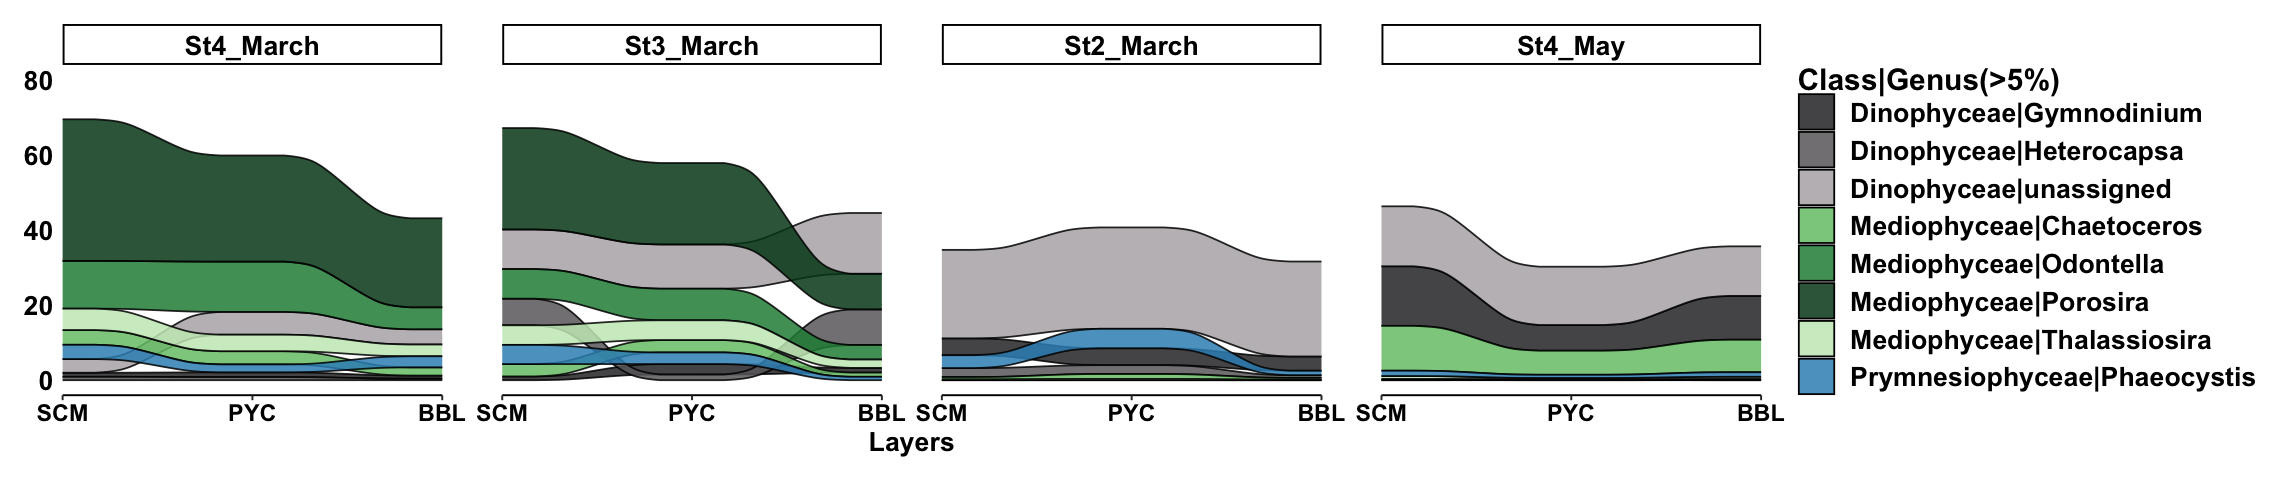

In [469]:
photo_df <- Oyashio18sMetadata_df %>%
                            filter(Station %in% c("St2_March","St3_March","St4_March","St4_May"))%>%
                            filter(Particle_types=="SK" & PotentialTrophicMode  %in% c("Phototroph","Unknown"))%>%
                            group_by(Station,Sample,Layers,Class,Genus)%>%
                            summarise(genus_ab = sum(asvCount)/337.62,.groups = "drop")%>%
                            tidyr::unite(re_genus,Class,Genus,sep="|", remove = FALSE) %>% 
                            mutate(across(Layers, factor, levels=c("SCM","PYC","BBL"))) %>%
                            mutate(across(Station, factor, levels=c("St4_March","St3_March","St2_March","St4_May"))) %>%
                            {select_genus <- unique(.$re_genus[.$genus_ab >= 5]); 
                            filter(., re_genus %in% select_genus)} 
options(repr.plot.width=19, repr.plot.height=4)
ggplot(photo_df, aes( x = Layers, y = genus_ab, alluvium = re_genus)) + 
    geom_alluvium(aes(fill = re_genus), colour = "black", alpha = 0.85, decreasing = FALSE,)+
    facet_wrap(~factor(Station),ncol = 4)+theme_classic2()+
    coord_cartesian(ylim =  c(0,80))+
    scale_x_discrete(expand = c(0, 0)) +
    scale_fill_manual(name = "Class|Genus(>5%)",values=c("#2e2d30","#6a686a","#b4b0b4", "#74c476", "#238b45","#00441b","#c7e9c0","#3690c0"))+
    theme(legend.position="right",
          legend.title=element_text(size=18,face = "bold",colour = "#000000"),
          legend.text=element_text(size=16,face = "bold",colour = "#000000"),
          legend.key.size = unit(0.8,"cm"),
          plot.margin=unit(c(1,1,1,1), units="line"),
          legend.margin=margin(0,0,0,10),
          legend.spacing.y  = unit(0, 'cm'),
          strip.text.x = element_text(size = 16, colour = "#000000",face="bold"),
          axis.text.x = element_text(size=14,face = "bold",colour ="#000000"),
          axis.text.y=element_text(size=16,face = "bold",colour ="#000000"),
          axis.title.x=element_text(size = 16,face="bold",colour ="#000000"),
          axis.title.y=element_blank(),
          axis.line.y = element_line(color="white", linewidth = 0),
          axis.ticks.y = element_line(color = "white",linewidth = 0),
          panel.spacing.x=unit(2.5, "lines"))
        #   guides(fill = guide_legend(title.position = "top", ncol = 2)) 

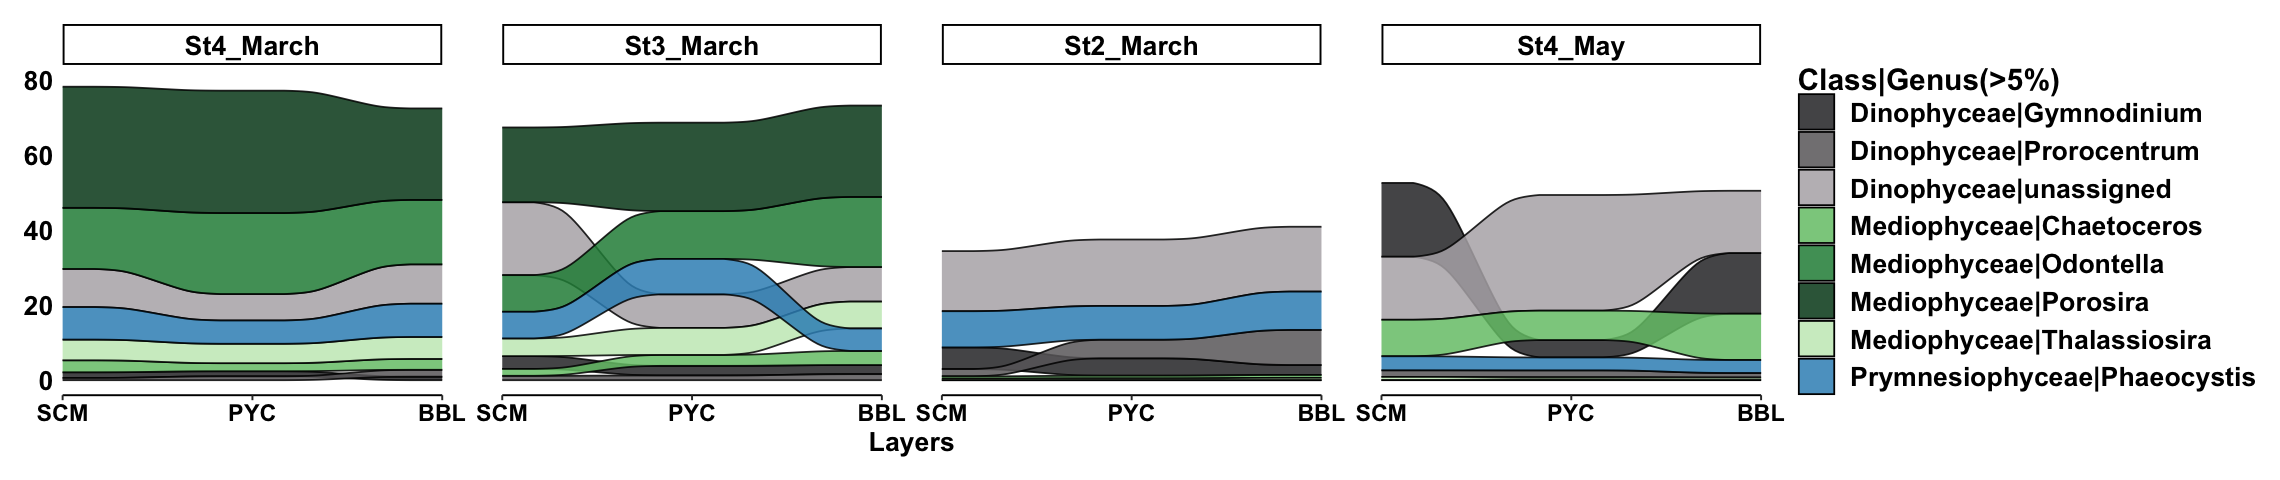

In [7]:
photo_df <- Oyashio18sMetadata_df %>%
                            filter(Station %in% c("St2_March","St3_March","St4_March","St4_May"))%>%
                            filter(Particle_types=="SS" & PotentialTrophicMode  %in% c("Phototroph","Unknown"))%>%
                            group_by(Station,Sample,Layers,Class,Genus)%>%
                            dplyr::summarise(genus_ab = sum(asvCount)/337.62,.groups = "drop")%>%
                            tidyr::unite(re_genus,Class,Genus,sep="|", remove = FALSE) %>% 
                            mutate(across(Layers, factor, levels=c("SCM","PYC","BBL"))) %>%
                            mutate(across(Station, factor, levels=c("St4_March","St3_March","St2_March","St4_May"))) %>%
                            {select_genus <- unique(.$re_genus[.$genus_ab >= 5]); 
                            filter(., re_genus %in% select_genus)} 
options(repr.plot.width=19, repr.plot.height=4)
ggplot(photo_df, aes( x = Layers, y = genus_ab, alluvium = re_genus)) + 
    geom_alluvium(aes(fill = re_genus), colour = "black", alpha = 0.85, decreasing = FALSE,)+
    facet_wrap(~factor(Station),ncol = 4)+
    ggpubr::theme_classic2()+
    coord_cartesian(ylim =  c(0,80))+
    scale_x_discrete(expand = c(0, 0)) +
    scale_fill_manual(name = "Class|Genus(>5%)",values=c("#2e2d30","#6a686a","#b4b0b4", "#74c476", "#238b45","#00441b","#c7e9c0","#3690c0"))+
    theme(legend.position="right",
          legend.title=element_text(size=18,face = "bold",colour = "#000000"),
          legend.text=element_text(size=16,face = "bold",colour = "#000000"),
          legend.key.size = unit(0.8,"cm"),
          plot.margin=unit(c(1,1,1,1), units="line"),
          legend.margin=margin(0,0,0,10),
          legend.spacing.y  = unit(0, 'cm'),
          strip.text.x = element_text(size = 16, colour = "#000000",face="bold"),
          axis.text.x = element_text(size=14,face = "bold",colour ="#000000"),
          axis.text.y=element_text(size=16,face = "bold",colour ="#000000"),
          axis.title.x=element_text(size = 16,face="bold",colour ="#000000"),
          axis.title.y=element_blank(),
          axis.line.y = element_line(color="white", linewidth = 0),
          axis.ticks.y = element_line(color = "white",linewidth = 0),
          panel.spacing.x=unit(2.5, "lines"))
        #   guides(fill = guide_legend(title.position = "top", ncol = 2)) 

## Part V Metazoa

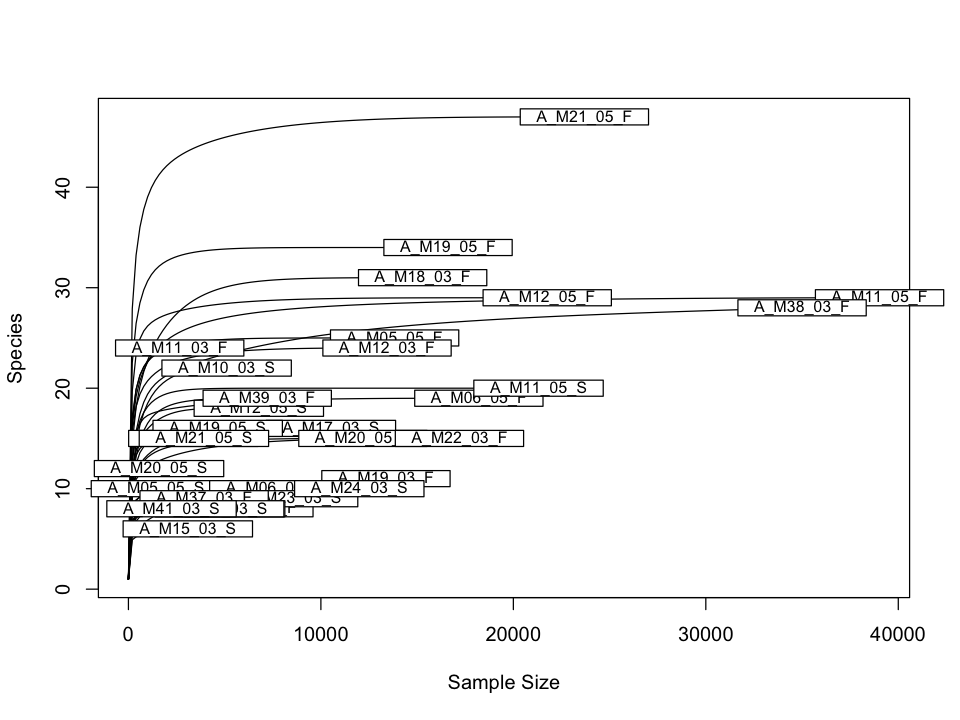

In [41]:
# set path
env_path <- "/Users/yangqingwei/Library/CloudStorage/OneDrive-KyotoUniversity/Oya18S/00-ori"
Process_path <- "/Users/yangqingwei/Library/CloudStorage/OneDrive-KyotoUniversity/Oya18S/02_proce"
# input file was directly putput from the qiime2 pipeline
asv <- read.table(file.path(env_path,"out8-derep-filtered_table_clustered_ASV_with_tax.tsv"),skip = 1,sep = "\t", comment.char = "",check.names = FALSE,header = 1)%>%
  mutate(across(everything(), ~str_replace_all(., " ", "")))%>% # remove space
  separate(taxonomy, into = c("Domain", "Supergroup", "Division", "Subdivision", "Class", "Order", "Family", "Genus", "Species"), sep = ";", fill = "right") %>%
  mutate(across(everything(), ~str_replace_all(., ":nucl", "")))%>%
  #split taxonomy columns
  replace_na(list(Domain = "unassigned", Supergroup = "unassigned", Division = "unassigned", Subdivision = "unassigned", Class = "unassigned", Order = "unassigned", Family = "unassigned", Genus = "unassigned", Species = "unassigned")) %>%
  filter(Domain != "unassigned")


asv_metazoan <- asv %>% filter(Subdivision == "Metazoa") %>%
                              mutate(ASVID = paste("ASV", row_number(), sep = ""))

asv_metazoan_rarefy_df <- asv_metazoan %>% select(ASVID, starts_with("A_M"))                           
asv_metazoan_taxon <- asv_metazoan %>% select(ASVID,Subdivision,Class,Order,Family,Genus,Species)
precess_df <- melt(asv_metazoan_rarefy_df, id=c("ASVID"))

min_n_seqs <-  precess_df %>%
  mutate(value = as.numeric(value)) %>%
  group_by(variable) %>%
  summarise(n_seqs=sum(value)) %>%
  summarise(min=min(n_seqs)) %>%
  pull(min)
rarefy_df1 <- precess_df %>%
  pivot_wider(names_from = ASVID,values_from = "value") %>%
  as.data.frame( )

rownames(rarefy_df1) <- rarefy_df1$variable
rarefy_df1 <- rarefy_df1[,-1] %>% mutate(across(everything(), ~ as.numeric(as.character(.))))
#Vegan rarefy
vegans <- rarefy(rarefy_df1,min_n_seqs) %>%
  as_tibble(rownames = "variable")

sub_asv_metazoan <- as.data.frame(t(rrarefy(rarefy_df1,sample=min_n_seqs)))

# set_size(8,6)
options(repr.plot.width=8, repr.plot.height=6)
FigS2 <- map_dfr(rarecurve(rarefy_df1,step=199),bind_rows) %>% 
  bind_cols(Group=row.names(rarefy_df1),.) %>%
  pivot_longer(-Group) %>%
  drop_na() %>%
  mutate(n_seqs=as.numeric(str_replace(name,"N",""))) %>%
  ggplot(aes(x=n_seqs,y=value,group=Group))+
  geom_line(linewidth=2,colour ="#525252") +
  geom_vline(xintercept = min_n_seqs,color="#000000",linewidth=2)+
  xlab("#reads")+
  ylab("#ASVs")+
  theme_classic()+
  theme(axis.text.y = element_text(size=20,face = "bold",colour ="#000000"),
        axis.text.x = element_text(size=20,face = "bold",colour ="#000000"),
        axis.title.x=element_text(size = 30,face="bold",colour ="#000000"),
        axis.title.y=element_text(size = 30,face="bold",colour ="#000000"))

In [ ]:
metazoan_df <- sub_asv_metazoan %>%
                                rownames_to_column(var="ASVID")%>%
                                left_join(asv_metazoan_taxon, by = "ASVID")%>%
                                mutate(sum_AR = rowSums(select(.,starts_with("A_M")))) %>%
                                filter(sum_AR != 0) %>%
                                select(-sum_AR) %>%
                                pivot_longer(cols=starts_with("A_M"), names_to = "Sample",values_to = "asvCount")%>%
                                left_join(sample_info_df,by="Sample")%>%
                                tidyr::unite(label, Layers,Particle_types, sep="_")%>%
                                mutate(across(label,factor,levels=c("SCM_SS","SCM_SK","PYC_SS","PYC_SK","BBL_SS","BBL_SK")))%>%
                                mutate(across(Station,factor,levels=c("St4_March","St3_March","St2_March","St4_May","St2_May","St1_May")))%>%
                                mutate(Taxon = case_when(Family %in% c("Maxillopoda") ~ str_c("Copepoda",Genus,sep="|"),
                                                         Class %in% c("Annelida","Cnidaria","Ctenophora","Mollusca","Urochordata") ~ Class,
                                                         TRUE ~ "Others"))%>%
                                group_by(Sample,Station,label,Taxon) %>%
                                dplyr::summarize(num_asv = sum(asvCount > 0, na.rm = TRUE),
                                          nums_seq = sum(asvCount, na.rm = TRUE),.groups = "drop")

                                

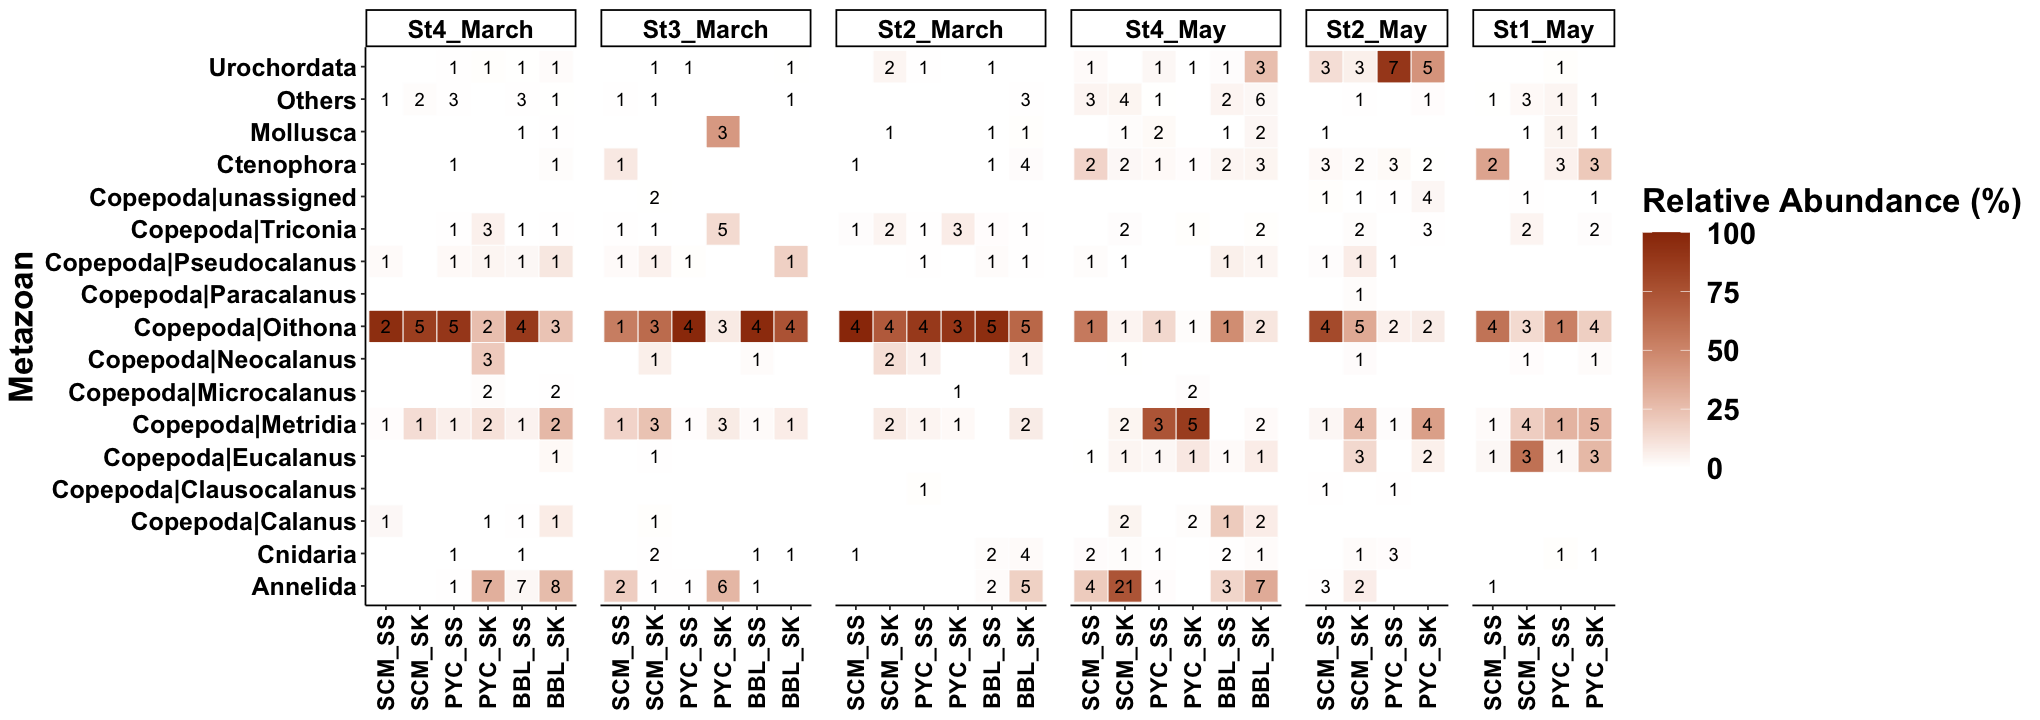

In [57]:
options(repr.plot.width=17, repr.plot.height=6)
my_heatmap <- ggplot(metazoan_df, aes(x = label, y =Taxon , fill = nums_seq/14.29))+
    geom_tile(color = "white", size = 0.25) +
    scale_fill_gradient(low = "white", high = "#993404",limits=c(0,100)) +
    geom_text(aes(label = ifelse(num_asv > 0, as.character(num_asv), ""))) +
    facet_grid(~Station,scales = "free",space="free")+
    ylab("Metazoan")+
    labs(fill="Relative Abundance (%)")+
    theme_classic() +
    theme(axis.title.x=element_blank(),
        axis.text.x = element_text(angle = 90,vjust=0.5,hjust = 0.5,size = 14, colour = "#000000",face = "bold"),
        axis.text.y=element_text(size = 15,colour = "#000000",face = "bold"),
        axis.title.y=element_text(size = 20, colour = "#000000",face = "bold"),
        strip.text.x = element_text(size = 15, colour = "#000000",face = "bold"),
        panel.spacing.x=unit(1, "lines"),
        panel.spacing.y=unit(0.5, "lines"),
        legend.position="right",
        legend.title=element_text(size=20, colour = "#000000",face = "bold"),
        legend.text=element_text(size=18, colour = "#000000",face = "bold"),
        legend.key.size = unit(1,"cm"))
my_heatmap
